In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [10]:
dataset_name = "W19_comb"
df_list = [ "BES_Panel", "BES_reduced_with_na"]

%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_pickle(data_subfolder + dataset_filename.replace('.dta','.zip'),compression='zip')
    else:
        globals()[df]  = pd.read_pickle(data_subfolder + df + '.zip',compression='zip' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )

In [3]:
# BES_Panel = pd.read_pickle("..\\BES_analysis_data\\"+"W19_comb"+os.sep+"BES2019_W19_Panel_v0.1_cleaned.zip",compression='zip')

In [4]:
# Fix up all the datasets we'll be using (make sure all categories correctly/consistently ordered)
immig_var_stub = ["immigEcon","immigCultural","immigSelf","immigrationLevel","immigContributeTake",
                  "immigrantsWelfareState","controlImmig","effectsEUImmigration","euPriorityBalance",
                  "changeImmig","changeImmigLab","govtHandleImmig","labHandleImmig",
                  "asylumMore","euMore","noneuMore","studentsMore","familiesMore",
                  "responsibleImmig","achieveReduceImmig",
                  "conPriorities_immig","labPriorities_immig","ldPriorities_immig","ukipPriorities_immig",
                  "dealPriority","ukCoopMovement","negotiationSpecifics","benefitsToMigrants"]

fix_cat_dict = {}
# not sure about best way to line up "expectation" variables
fix_cat_dict['changeImmig']=['Getting a lot lower', 'Getting a little lower','Staying about the same',
                             'Getting a little higher', 'Getting a lot higher',  "Don't know" ]
fix_cat_dict['effectsEUImmigration'] = ['Much lower', 'Lower', 'About the same', 'Higher', 'Much higher', "Don't know"]
fix_cat_dict['controlImmig']=['No control at all', 'A little control', 'Some control', 'A lot of control', 'Complete control', "Don't know"]

# lets try to get every axis pointing in the same "sentiment" direction
fix_cat_dict['immigEcon']=['Bad for economy','2', '3', '4', '5', '6', 'Good for economy',  "Don't know"]
fix_cat_dict['immigCultural']=['Undermines cultural life', '2', '3', '4', '5', '6', 'Enriches cultural life', "Don't know" ]
fix_cat_dict["immig(Self|Con|Lab|TIG|Brexit|Green|UKIP|PC|SNP|LD)W"] = ['Allow many fewer', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Allow many more', "Don't know"]
fix_cat_dict['(students|eu|asylum|families|noneu)More'] = ['Many fewer', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Many more', "Don't know"]
fix_cat_dict['immigrantsWelfareState'] = ['Strongly agree', 'Agree', 'Neither agree nor disagree', 'Disagree', 'Strongly disagree', "Don't know"]
fix_cat_dict['immigContributeTake'] = ['Get more than they pay', '2.0', '3.0', '4.0',
                                       '5.0', '6.0', 'Pay more than they get', "Don't know"]
fix_cat_dict['euPriorityBalance'] = ['Control immigration', '9', '8', '7', '6', '5', '4', '3', '2', '1', 'Access to the single market', "Don't know"]
fix_cat_dict['immigrationLevel'] = ['Decreased a lot', 'Decreased a little', 'Left the same as it is now',
                                    'Increased a little', 'Increased a lot',  "Don't know"]
fix_cat_dict['ukCoopMovement'] = ["Bad for Britain", "Neither good nor bad for Britain", "Good for Britain", "Don't know"]
fix_cat_dict['benefitsToMigrants'] = ['Immediately on arrival','After living in GB for a year',
                                      'After they have worked and paid taxes for at least four years',
                                      'After they become a British citizen', 'Never', "Don't know"]



# fix_cat_dict['immigrantsWelfareState'] = ['Strongly disagree', 'Disagree',  'Neither agree nor disagree','Agree', 'Strongly agree',"Don't know", ]
# mostly dealPrioritImmig, but might be worth setting alongside the other dealPriority variables
fix_cat_dict['dealPriority'] = ['Not important at all', 'Not very important', 'Somewhat important',
                                'Very important', 'Extremely important' , "Don't know"]

# fix_cat_dict['euPriorityBalance'] = ['Access to the single market', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Control immigration', "Don't know"]
fix_cat_dict['(lab|govt)HandleImmig'] = ['Very badly', 'Fairly badly', 'Neither well nor badly', 'Fairly well', 'Very well', "Don't know"]
fix_cat_dict['responsibleImmig(Conservatives|LibDems|Labour|ScottishGovt|WelshGovt|None|DontKnow)'] = ["No","Yes","Don't know"]
fix_cat_dict['achieveReduceImmig(Brexit|Con|Grn|LD|Lab|None|PC|SNP|TIG|UKIP)'] = ["No","Yes","Don't know"]

fix_cat_dict["(con|lab|ld|ukip)Priorities_immig"] = ["No","Yes","Don't know"]

# my time plotting function assumes variable names won't contain _ - quick hack to circumvent having to change that
BES_Panel[[x.replace("_1","ContinuePayingMoney").replace("_2","AcceptingFoM").replace("_3","AcceptingEUReg").replace("_none","Nothing") for x in search(BES_Panel,"negotiationSpecifics").index]] = BES_Panel[[x for x in search(BES_Panel,"negotiationSpecifics").index]]

fix_cat_dict["negotiationSpecifics"] = ["No","Yes","Don't know"]

def cat_2_num_drop_dk(x):
    if x.dtype.name=='category':
        return x.replace("Don't know",np.nan).cat.remove_unused_categories().cat.codes.replace(-1,np.nan).astype('UInt16')
    else:
        return x

def fix_cats(fix_cat_dict):
    for key in fix_cat_dict.keys():
        BES_Panel[ match(BES_Panel, key ).index ] = BES_Panel[ match(BES_Panel,key ).index ]\
            .apply( lambda x: x.cat.set_categories( fix_cat_dict[key], ordered =True ) )
    
fix_cats(fix_cat_dict)

def weighted_mean(x, **kws):
    val, weight = map(np.asarray, zip(*x))
    val, weight = val[~np.isnan(val)],weight[~np.isnan(val)]
    return (val * weight).sum() / weight.sum()

# max_wave = int(re.match("W(\d+)_",dataset_name).groups()[0])
# num_to_wave = {x:"W"+str(x) for x in range(1,max_wave+1)}
# wts_for_wave = { "W"+str(y):[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,max_wave+1) }
wave_to_date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"][["Wave No","Date_Start"]].set_index("Wave No")["Date_Start"]

max_wave = np.max([int(x.replace("wave","")) for x in match(BES_Panel,"wave\d+$").index])
num_to_wave = {x:"W"+str(x) for x in range(1,max_wave+1)}
wts_for_wave = { "W"+str(y):[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"(_result)?"+"$",x)][0] for y in range(1,max_wave+1) }

# drop_ids = BES_Panel.loc[BES_Panel[wts_for_wave.values()].isnull().all(axis=1)].index
# BES_Panel.drop(drop_ids, inplace=True)

waves = BES_Panel[search(BES_Panel,"wave").index].copy()
wts = BES_Panel[wts_for_wave.values()].isnull().copy()
wts.columns = waves.columns
drop_ids = BES_Panel.loc[((wts*waves).sum(axis=1)>0)].index
BES_Panel.drop(drop_ids, inplace=True)

# fix endtimeW3 bug!
BES_Panel.loc[BES_Panel["endtimeW3"]=='1970-01-01 00:00:00',"endtimeW3"] = \
    BES_Panel[BES_Panel["endtimeW3"]=='1970-01-01 00:00:00']["starttimeW3"].values

# this is also suspect - date not unreasonable, but overlaps with a different wave! (3 days between start/end)
# 41222   2015-03-27 18:11:37.047
# Name: starttimeW5, dtype: datetime64[ns]
BES_Panel.loc[BES_Panel["starttimeW5"]=='2015-03-27 18:11:37.047000064',"starttimeW5"] = \
    BES_Panel[BES_Panel["starttimeW5"]=='2015-03-27 18:11:37.047000064']["endtimeW5"].values

# still some overlap between waves 4 and 5

midpoint_dict = {}
# create correct midpoints (technically we should weight these!)
n = 1
for wave_no in range(1,max_wave+1):
    wave = "W"+str(wave_no)
#     print(wave)

    BES_Panel["midpoint"+wave] = pd.qcut(BES_Panel["endtime"+wave]+((BES_Panel["endtime"+wave]-BES_Panel["starttime"+wave])/2),n)
    date_cats_dict = {BES_Panel["midpoint"+wave].cat.categories[x]:(BES_Panel["midpoint"+wave].cat.categories[x].left+ (BES_Panel["midpoint"+wave].cat.categories[x].right - BES_Panel["midpoint"+wave].cat.categories[x].left)/2).strftime("%Y-%m-%d") for x in range(n)}
    BES_Panel["midpoint"+wave] = pd.to_datetime(BES_Panel["midpoint"+wave].replace(date_cats_dict))  
    BES_Panel["endpoint"+wave] = pd.to_datetime(BES_Panel["endtime"+wave]).max() 
    BES_Panel["startpoint"+wave] = pd.to_datetime(BES_Panel["starttime"+wave]).min() 
    
    midpoint_dict[wave] = BES_Panel["midpoint"+wave].dropna().values[0]

In [5]:
def time_series(var_name,title,subtract_var=False,retain_var=True,specific_dates=True, specific_suffix_set="([a-zA-Z]*)",
                use_midpoints=True,col_name="party",dk_str="Don't know",max_y_size=10.0,min_waves_included=2,max_y_size_dict=None):

    whole_wave_dk_average = True
    df=pd.DataFrame()
    df2 =pd.DataFrame()
    df_wts =pd.DataFrame()
    df_dates = pd.DataFrame()
    
    if subtract_var:
        title=title+"\n(where respondents place parties relative to their own preference set at 0.5)"

    wave_list = []
    redist_vars = pd.Series([re.match(var_name+specific_suffix_set+"($|W\d+)",x).groups()[0] for x in BES_Panel.columns\
                             if re.match(var_name+specific_suffix_set+"($|W\d+)",x)]).value_counts()
    redist_vars = redist_vars[redist_vars>=min_waves_included].index

   
    
    for subj in redist_vars:
        for wave in ["W"+str(x) for x in range(1,17)]:
            if var_name+subj+wave not in BES_Panel.columns:
                continue
            else:
                wave_list.append(wave)
            if max_y_size_dict:
                max_y_size = max_y_size_dict[subj]
            
            df[var_name+"num_"+subj+"_"+wave] = BES_Panel[var_name+subj+wave].replace(dk_str,np.nan).cat.codes.replace(-1,np.nan)/max_y_size

            
            df2[var_name+"dk_"+subj+"_"+wave] = BES_Panel[var_name+subj+wave]==dk_str
            df2[var_name+"dk_"+subj+"_"+wave][BES_Panel[var_name+subj+wave].isnull()] = np.nan

           
            
    for wave in pd.unique(wave_list):        
        df_wts["wt_"+wave] = BES_Panel[wts_for_wave[wave]]
        
        if use_midpoints:
            df_dates["dt_"+wave] = BES_Panel["midpoint"+wave]
        else:
            df_dates["dt_"+wave] = (BES_Panel["starttime"+wave]+(BES_Panel["endtime"+wave]-BES_Panel["starttime"+wave])/2)


    df2.columns = df2.columns.str.split('_', expand=True)
    df2 = df2.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df_wts.columns = df_wts.columns.str.split('_', expand=True)
    df_wts = df_wts.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df_dates.columns = df_dates.columns.str.split('_', expand=True)
    df_dates = df_dates.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df.columns = df.columns.str.split('_', expand=True)
    df = df.stack(dropna=False)\
            .reset_index()\
            .rename(columns={'level_1':"wave"})\
            .rename(columns={'level_0':"id"}) 

    content_columns = [(var_name+"dk",x) for x in redist_vars]
    df["wt"] = df_wts["wt"]
    df[content_columns] = df2[content_columns]
    df["date"] = df_dates["dt"]
    content_columns = [(var_name+"num",x) for x in redist_vars]+[(var_name+"dk",x) for x in redist_vars]
    # only keep rows with content (variable values/dks)

    df = df[df[content_columns].notnull().any(axis=1)]

    df.loc[:,"wt"] = df.loc[:,"wt"].fillna(1.0).values
    temp_ind_name = "temp_index"



    df[temp_ind_name] = list(zip(df["wave"],df["wt"],df["date"]))
    df = df.set_index(temp_ind_name).drop(["id","wave","wt","date"],axis=1)



    if subtract_var:
        if retain_var:
            focal_vars = [x for x in df.columns if (var_name+"num" in x) and (subtract_var not in x)]
            df[focal_vars] = df[focal_vars].apply(lambda x: x-df[(var_name+"num",  subtract_var)])+0.5
        else:
            focal_vars = [x for x in df.columns if var_name+"num" in x]
            df[focal_vars] = df[focal_vars].apply(lambda x: x-df[(var_name+"num",  subtract_var)])+0.5
            df.drop((var_name+"num",  subtract_var),axis=1,inplace=True)


    flat_df_num = df.stack().reset_index().rename(columns={'level_1':col_name})

    if specific_dates:
        flat_df_num["wave"] = flat_df_num[temp_ind_name].apply(lambda x:x[0])    
    else:
        flat_df_num["wave"] = flat_df_num[temp_ind_name].apply(lambda x:int(x[0].split("W")[1]))

    flat_df_num["wt"]   = flat_df_num[temp_ind_name].apply(lambda x:x[1])
    flat_df_num["date"] = flat_df_num[temp_ind_name].apply(lambda x:x[2])
    
    
    
    flat_df_num.drop(temp_ind_name,axis=1,inplace=True)
    flat_df_num[col_name] = flat_df_num[col_name].astype('category')

    flat_df_num[var_name+"_wts"] = list(zip(flat_df_num[var_name+"num"],flat_df_num["wt"]))
    flat_df_num[var_name+"_dk"] = list(zip(flat_df_num[var_name+"dk"],flat_df_num["wt"]))

    
    if not specific_dates:
        flat_df_num["date"] = flat_df_num["wave"].apply(lambda x: wave_to_date[x])
        flat_df_num["date"] = pd.to_datetime(flat_df_num["wave"] , format="%b-%y")

        
    return flat_df_num, df, df2, 

In [6]:
def sample_size(x, **kws):
    global max_sample_size    
    return len(x)/max_sample_size

def between_wave_retention(*args, **kwargs):
    global position_in_var_list
    var_name = kwargs['var_name'][position_in_var_list]
    position_in_var_list = position_in_var_list+1
    color = kwargs['color']
    label = kwargs['label']
    alpha = kwargs['alpha']
    df = BES_Panel[match(BES_Panel,var_name+"($|W\d+)").index].apply(lambda x: x.cat.codes.replace(-1,np.nan)).diff(axis=1).notnull().sum()/match(BES_Panel,var_name+"($|W\d+)")
    waves_present = {"W"+x.split("W")[-1]:BES_Panel["midpointW"+x.split("W")[-1]].dropna().values[0] for x in df.index}    
    df.index = [BES_Panel["midpointW"+x.split("W")[-1]].dropna().values[0] for x in df.index]
    df.drop(df.index[0],inplace=True)
    sns.lineplot(data=df,color=color,label=label,alpha=alpha)

    for wave in waves_present.keys():
        plt.text(x=waves_present[wave],y=0,s=wave, rotation=90, fontsize=12)   
        
def plot_time_series(var_name,specific_suffix_set,title,col_name,col_wrap,treatment):
    dk_str="Don't know"
    lowest_alpha=0.3
    low_alpha=0.5    
    date_dict = {"22 May 2014":"EE","7 May 2015":"GE","23 June 2016":"EU","8 June 2017":"GE","23 May 2019":"EE"}
    date_col_dict = {"EE":'green',"GE":'red',"EU":'blue'}    
    
    max_y_size_dict = {x: len(BES_Panel[match(BES_Panel,var_name+x+"($|W\d+)").index[0]].cat.remove_categories(dk_str).cat.categories)-1 for x in specific_suffix_set.replace("(","").replace(")","").split("|") }
    # max_y_size=len(BES_Panel[ match(BES_Panel,var_name+specific_suffix_set+"($|W\d+)").index[0] ].cat.remove_categories(dk_str).cat.categories)-1,
    flat_df_num, df, df2, = time_series(var_name,title,specific_suffix_set=specific_suffix_set,col_name="party",
                                max_y_size_dict = max_y_size_dict,
                                dk_str=dk_str,min_waves_included=2,use_midpoints=False)
    
#     raise Exception
    flat_df_num["wave_midpoint"] = flat_df_num["wave"].apply( lambda x: midpoint_dict[x] )
    
    

    global max_sample_size
    global position_in_var_list
    position_in_var_list=0
#     max_sample_size = flat_df_num["dk"].value_counts().max()
    max_sample_size = flat_df_num.groupby(["party","wave"]).apply(lambda x: len(x)).max()


    g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=col_wrap, ylim=(0.0, 1.0), legend_out=False, height=height);
    
#     raise Exception
    
    g.map(sns.lineplot, "wave_midpoint",var_name+"_wts", estimator=weighted_mean,ci=None, label="Mean answer",
          err_style="bars", markers=True, dashes=False);
    g.map(sns.lineplot, "wave_midpoint",var_name+"_dk", color='r', estimator=weighted_mean,ci=None,
          err_style="bars", label="DK fraction",markers=True, dashes=False, alpha=low_alpha);
    g.map(sns.lineplot, "wave_midpoint","wave", color='g', estimator=sample_size,ci=None,
          label="Sample Size\n(% of max: "+str(max_sample_size)+")",markers=True, dashes=False, alpha=low_alpha);
    g.map(between_wave_retention, "wave_midpoint","wave", color='k', var_name=[var_name+x for x in g.col_names],
          label="Retention",markers=True, dashes=False, alpha=low_alpha);
    

    for date in date_dict.keys():
        if flat_df_num["wave_midpoint"].min()<pd.to_datetime(date) and flat_df_num["wave_midpoint"].max()>pd.to_datetime(date):
            g.map(plt.axvline, x=pd.to_datetime(date), ls='--', c=date_col_dict[date_dict[date]], linewidth=1,
                  alpha=lowest_alpha, label=date_dict[date] )
            
    g.map(plt.axhline, y=0.5, ls='-.', c='grey',linewidth=1, alpha=lowest_alpha)

    g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
    g.fig.suptitle(title, y=1.0+0.03*len(title.split("\n")));
    [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

    output_subfolder = create_subdir(BES_output_folder, treatment)
    g.savefig(output_subfolder +clean_filename(var_name +specific_suffix_set)+ ".png", bbox_inches='tight')
    return flat_df_num

In [15]:
def MII_Immigration_transform(x):
    if pd.isnull(x):
        return np.nan
    elif x=="Immigration":
        return "Yes"
    else:
        return "No"

In [16]:
# technically we should add Don't knows from the MII ("did they answer") variable!

BES_Panel[[x.replace("small_mii_cat","ImmigrationMII") for x in search(BES_Panel,"small_mii_cat").index]] = BES_Panel[search(BES_Panel,"small_mii_cat").index].applymap(lambda x: MII_Immigration_transform(x)).astype('category').apply(lambda x:x.cat.set_categories(["No","Yes","Don't know"]))


In [17]:
# search(BES_Panel,"ImmigrationMII")

In [ ]:
%%time
var_name = ""
title= "\n".join(["As far as you're concerned, what is the SINGLE MOST important issue facing the country at the present time?",
                  "(all responses categorised as 'immigration' in BES small_cat_mii)"])
specific_suffix_set = "(ImmigrationMII)"
col_wrap = 1
height   = 10

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

# Immigration Expectation variables

In [ ]:
%%time
var_name = ""
title= "\n".join(["Would [The Conservatives] be successful – if elected – in reducing the level of immigration?",
                  "Do you think that the level of immigration is getting higher, getting lower or staying about the same?",
                  "If there were a *Labour* UK government today, do you think that the level of immigration would be getting higher, getting lower or staying about the same?",
                  "How much control do you think Britain has/will have over immigration to the UK?"])
specific_suffix_set = "(changeImmig|controlImmig|changeImmigLab|achieveReduceImmigCon)"
col_wrap = 2
height   = 6

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

# quick check of NINO data

In [114]:
nino = pd.read_stata( BES_data_folder+os.sep+"Portes"+os.sep+"NINO Constituencies - Annual.dta" )
nino

,id,year,constituency,EU_reg,other_europe,asia,rest_world,other,total,postref,nonEU_reg,tot,yearnum,con,EUpostref,EUprefre,dEU_reg,dnonEU_reg,dEUpostref
0,Aberavon2011-2012,2011-2012,Aberavon,37,0,42,7,0,95,0,49.0,86.0,2011-2012,Aberavon,0.0,-37.0,NaN,NaN,NaN
1,Aberavon2012-2013,2012-2013,Aberavon,32,0,34,0,0,79,0,34.0,66.0,2012-2013,Aberavon,0.0,-32.0,-5.0,-15.0,0.0
2,Aberavon2013-2014,2013-2014,Aberavon,40,0,24,0,0,69,0,24.0,64.0,2013-2014,Aberavon,0.0,-40.0,8.0,-10.0,0.0
3,Aberavon2014-2015,2014-2015,Aberavon,51,0,33,11,0,108,0,44.0,95.0,2014-2015,Aberavon,0.0,-51.0,11.0,20.0,0.0
4,Aberavon2015-2016,2015-2016,Aberavon,73,0,30,7,0,118,0,37.0,110.0,2015-2016,Aberavon,0.0,-73.0,22.0,-7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,York Outer2013-2014,2013-2014,York Outer,176,5,134,45,0,370,0,184.0,360.0,2013-2014,York Outer,0.0,-176.0,18.0,-24.0,0.0
4420,York Outer2014-2015,2014-2015,York Outer,275,28,175,64,0,540,0,267.0,542.0,2014-2015,York Outer,0.0,-275.0,99.0,83.0,0.0
4421,York Outer2015-2016,2015-2016,York Outer,198,6,160,47,0,416,0,213.0,411.0,2015-2016,York Outer,0.0,-198.0,-77.0,-54.0,0.0
4422,York Outer2016-2017,2016-2017,York Outer,217,5,107,49,0,388,1,161.0,378.0,2016-2017,York Outer,217.0,0.0,19.0,-52.0,19.0


* year -> when in the year? Is there a specific accounting year end point?
* EU_reg|other_europe|asia|rest_world|other
* adds up to same as "tot"

* what is "other" that it isn't caught in "rest_world"?


* but not "total" - what is "total" and why doesn't it agree with the sum of EU_reg|other_europe|asia|rest_world|other
* total-sum = 4791597 - discrepancy of 9121?? matches no other column 

* nonEU_reg == sum(other_europe|asia|rest_world|other)
* postref -> ah - binary flag for before/after ref

* EUpostref -> looks like EU_reg x postref
* EUprefre -> looks like -EU_reg x (1-postref)

* dEU_reg -> change in EU_reg (from last year in same constituency)
* dnonEU_reg -> change in nonEU_reg (from last year in same constituency)
* dEUpostref -> dEU_reg x postref

# choice of which pairs of waves to try to focus an initial "drivers of change" analysis on


Impact of Euref Pre-Campaign Pair 1->7
Impact of Euref Campaign Pair 7->8
Impact of Euref Result Pair 8->10
Impact of Euref Post Result Pair 10->17



Best wave choice

immigEcon/Cult 7/8/10/11
    - 7->8->10 sharp, 10->11 weaker

changeImmig 7/8/10/11
    - no clear shift 7->8
    - 8->10 sharp, 8->11 okay
    
immigrantsWelfareState 7/8/10/11
    - sharp increase 7->8->10
    - weaker 10->11
    
ukCoopMovement 7/8/10
    - sharp increase 7->8->10
    
effectsEUImmigration 7/8/10/11
    - falls 7->8 ???
    - 8->10 increase
    - 10->11 flat

immigContributeTake 7/8
    - big shift 7->8    
    
immigSelf 7/8/9/10/11
    -(has partials in 12/13)
    - appears to dip 7->8, sharpest rise 8->9

controlImmig 8/9/10/11/13
    - tragically, wave 8 is only a partial sample - but super sharp transition
    - 9-> 10 actually falls, 9->11/10->11 small/large increase
    - falls again 11->13    
    
(eu|noneu|families|asylum|students)More 7/8/13
    - consistent increase 8->13
    - 7-8 sharper but less consistent (flat for eu, bump for noneu, neg for families)
    
achieveReduceImmigCon 7/9/10/11/12
    - 4->7 is a fall
    - 7->9-10->11 increase
    - 11->12 sharp fall, 12-> continuous fall

# Media variables

* all these variables reflect the "profile_newspaper_readership_201" yougov variable
* note that this is "Which daily newspaper do you read most often?"
* you could legitimately read the Express and Mail about as often and oscillate between
* also there's a huge editorial (and anecdotally I understand readership) difference between
* Mail on Sunday (Remain! - contains weekly TV listings) and the Daily Mail (Leave!)

* "profiles_newspaper2W16" is obviously just a "top up" sample
* "profile_newspaper" is an amalgamation of all the waves

* Full Waves 10, 11, 12, 13, 15

In [145]:
search(BES_Panel,"newspaper")

newspaperReadW15          30842
profile_newspaperW10      30237
profile_newspaperW11      30956
profile_newspaper2W12     34394
profile_newspaperW13      31136
profiles_newspaper2W16    13775
profile_newspaper         56590
dtype: int64

* they're a bit None heavy (and region matters)

In [12]:
BES_Panel["profile_newspaper"].value_counts()


None                                           17336
The Sun                                         7390
The Daily Mail / The Scottish Daily Mail        7333
The Mirror / Daily Record                       4400
The Guardian                                    4395
Other Newspaper                                 3720
The Daily Telegraph                             2703
The Times                                       2696
Other local daily morning newspaper             2240
The Independent                                 1318
The Express                                     1061
The Herald (Glasgow)                             559
The Daily Star / The Daily Star of Scotland      536
The Scotsman                                     388
The Financial Times                              313
The Western Mail                                 202
Name: profile_newspaper, dtype: int64

# BES Media module variables

* infoSource

* search(BES_Panel,"infoSource")

* During the last seven days, on average how much time (if any) have you spent per day following news about
* politics or current affairs from each of these sources?

* TV/Paper/Radio/Internet/People
* Full waves 4, 5, 6, 7, 8, 12, 13, 15

In [148]:
BES_Panel["infoSourceTVW4"].value_counts()

Less than 1/2 hour      8832
1/2 hour to 1 hour      8560
1 to 2 hours            5313
None, no time at all    4180
More than 2 hours       3497
Don't know              1063
Name: infoSourceTVW4, dtype: int64

* twitterUse: Full Waves 4, 5, 6, 12
* Do you use Twitter? Yes/No/DK (mostly No!, ~8000/30+k = Yes)

* ~8000 people that say Yes then asked
* twitterInfo(_1/2/3) Partial Sample Waves 4, 5, 12
* In the last 4 weeks, have you read news or found information about the upcoming general election or politics
* more generally that was tweeted by any of the following people or organisations? Tick all that apply
* twitterInfo_1: Candidates or parties on Twitter
* twitterInfo_2: Someone you know personally on Twitter
* twitterInfo_3: Other people on Twitter e.g. commentators, journalists, activists

* Yes/No/DK/Don't follow politics on twitter (mostly Don't follow politics on twitter)



* twitterInfof2f Partial Sample Wave 6
* During the election campaign, did you get news about politics and the election through twitter?
* Yes/No/DK

In [149]:
BES_Panel["twitterInfof2fW6"].value_counts()

Yes           4462
No            3806
Don't know     113
Name: twitterInfof2fW6, dtype: int64

* fbUse: Full Waves 4, 5, 6, 12
* Do you use Facebook? Yes/No/DK (mostly No!, ~20k/30+k = Yes)

* ~20000 people that say Yes then asked
* fbInfo(_1/2/3) Partial Sample Waves 4, 5, 12
* In the last 4 weeks, have you read news or found information about the upcoming general election or politics more
* generally that was posted on Facebook by any of the following people or organisations? Tick all that apply
* fbInfo_1 Candidates or parties on Facebook
* fbInfo_2 Someone you know personally on Facebook
* fbInfo_3 Other people on Facebook e.g. commentators, journalists, activists
* Yes/No/DK/Don't follow politics on facebook (mostly Don't follow politics on facebook - even moreso than twitter)


* fbInfof2fW6 Partial Sample Wave 6
* During the election campaign, did you get news about politics and the election through Facebook?
* Yes/No/DK

In [151]:
BES_Panel["fbInfo_1W4"].value_counts()

Don't follow politics on facebook    14308
No                                    3028
Yes                                   2589
Don't know                             994
Name: fbInfo_1W4, dtype: int64

* euSources Full Waves 7, 8
* Have you heard anything about the EU referendum from any of these during the last seven days?
* Please tick all that apply.
* euSources_1: Television
* euSources_2: Newspaper (including online)
* euSources_3: Radio
* euSources_4: Internet (not including online newspapers)
* euSources_5: Talking to other people

* Yes/No/DK

# need to download/open up the open-ended question dataset for
* tvWatch/radioList/paperRead/internetRead

* urk - ugly human data

* What are the most important Internet sources (including online newspapers) you read
* for information about politics and the election?
* List up to three websites or click next if there are no websites you can think of.

* TV/radio/newspaper/internet

* whole bunch of variables about visiting a party site/sharing party website/fb/twitter stuff -> ignoring

# geo variables

In [52]:
match(BES_Panel,"pano")
# every wave except 1

panoW11    48508
panoW12    34393
panoW13    30985
panoW14    32578
panoW2     30467
panoW3     27837
panoW6     28583
panoW1     30382
panoW5     31039
panoW7     32248
panoW8     33504
panoW9     30172
panoW10    32748
panoW15    31006
panoW16    39431
dtype: int64

In [53]:
match(BES_Panel,"gor")
# less regular update for regions

gorW11    30956
gorW12    34394
gorW14    31063
gorW15    30842
gorW16    37959
gorW13    30985
gorW2     30467
gorW3     27837
gorW6     28583
gor       66696
dtype: int64

In [54]:
match(BES_Panel,"profile_lea")
# more coarse than constituency!

profile_lea    60173
dtype: int64

In [55]:
BES_Panel["profile_lea"]

0        Cheshire West and Chester
1                           Surrey
2                     Lincolnshire
3                      Southampton
4                    Herefordshire
                   ...            
92582                          NaN
92583                          NaN
92584                          NaN
92585                          NaN
92586                          NaN
Name: profile_lea, Length: 92587, dtype: category
Categories (206, object): [Aberdeen City, Aberdeenshire, Angus, Argyll & Bute, ..., Wolverhampton, Worcestershire, Wrexham, York]

In [ ]:
### building test dataset for Jonathan Portes

In [7]:
search(BES_Panel,"immigEcon")

immigEconW1     30335
immigEconW2     30240
immigEconW3     28114
immigEconW4     31444
immigEconW7     30895
immigEconW8     33502
immigEconW10    30237
immigEconW11    30956
immigEconW13    31136
immigEconW14    31063
immigEconW15    30842
immigEconW16    37959
dtype: int64

In [9]:
BES_Panel["immigEconW8"].notnull() & (BES_Panel["immigEconW8"]!="Don't know") & BES_Panel["immigEconW10"].notnull() & (BES_Panel["immigEconW10"]!="Don't know")

0         True
1         True
2        False
3        False
4        False
         ...  
92582    False
92583    False
92584    False
92585    False
92586    False
Name: immigEconW8, Length: 92587, dtype: bool

In [32]:
BES_Panel["immigEconW8"].value_counts()

4                   6287
5                   6163
Bad for economy     5544
6                   4131
3                   3888
2                   3137
Good for economy    2474
Don't know          1878
Name: immigEconW8, dtype: int64

In [29]:
"("+"|".join(immig_var_stub)+")W(8|10)$"

'immigEcon|immigCultural|immigSelf|immigrationLevel|immigContributeTake|immigrantsWelfareState|controlImmig|effectsEUImmigration|euPriorityBalance|changeImmig|changeImmigLab|govtHandleImmig|labHandleImmig|asylumMore|euMore|noneuMore|studentsMore|familiesMore|responsibleImmig|achieveReduceImmig|conPriorities_immig|labPriorities_immig|ldPriorities_immig|ukipPriorities_immig|dealPriority|ukCoopMovement|negotiationSpecifics|benefitsToMigrantsW(8|10)$'

In [31]:
match(BES_Panel,"("+"|".join(immig_var_stub)+")W(8|10)$").index

Index(['changeImmigW8', 'benefitsToMigrantsW8', 'immigContributeTakeW8',
       'ukCoopMovementW8', 'effectsEUImmigrationW8',
       'immigrantsWelfareStateW8', 'controlImmigW8', 'immigEconW8',
       'immigCulturalW8', 'asylumMoreW8', 'euMoreW8', 'noneuMoreW8',
       'studentsMoreW8', 'familiesMoreW8', 'immigSelfW8', 'controlImmigW10',
       'euPriorityBalanceW10', 'ukCoopMovementW10', 'effectsEUImmigrationW10',
       'immigEconW10', 'immigCulturalW10', 'immigSelfW10', 'changeImmigW10',
       'changeImmigLabW10', 'immigrantsWelfareStateW10'],
      dtype='object')

In [17]:
smallW8W10_set = ["immigSelf","immigEcon","immigCultural","changeImmig","ukCoopMovement","effectsEUImmigration",
                  "immigrantsWelfareState",]

In [239]:
immig_var_stub = ["immigEcon","immigCultural","immigSelf","immigrationLevel","immigContributeTake",
                  "immigrantsWelfareState","controlImmig","effectsEUImmigration","euPriorityBalance",
                  "changeImmig","changeImmigLab","govtHandleImmig","labHandleImmig",
                  "asylumMore","euMore","noneuMore","studentsMore","familiesMore",
                  "responsibleImmig","achieveReduceImmig",
                  "conPriorities_immig","labPriorities_immig","ldPriorities_immig","ukipPriorities_immig",
                  "dealPriority","ukCoopMovement","negotiationSpecifics","benefitsToMigrants","childBenefitsRepatriate"]

In [240]:
wave_pairs = [("W1","W7"),("W7","W8"),("W8","W10"),("W10","W17")]

In [236]:
nino_df

,W1_nino,W7_nino,W8_nino,W10_nino,W17_nino
0,69.0,108.0,118.0,130.0,142.0
1,69.0,108.0,118.0,130.0,NaN
2,NaN,NaN,NaN,NaN,142.0
3,NaN,108.0,118.0,130.0,142.0
4,NaN,NaN,NaN,NaN,142.0
...,...,...,...,...,...
97153,768.0,NaN,NaN,NaN,NaN
97154,NaN,1071.0,905.0,NaN,NaN
97155,NaN,NaN,6347.0,NaN,NaN
97156,775.0,NaN,NaN,NaN,NaN


In [242]:
normed_df.index

Int64Index([    0,     3,     6,     8,     9,    13,    14,    15,    17,
               31,
            ...
            96951, 97021, 97024, 97031, 97041, 97061, 97073, 97082, 97122,
            97124],
           dtype='int64', length=11790)

In [245]:

nino_df.loc[normed_df.index,first_wave+"_nino"]
delta_substr

'D10_17'

,W1immigEcon,W7immigEcon,W1immigCultural,W7immigCultural,W1immigrantsWelfareState,W7immigrantsWelfareState,W1changeImmig,W7changeImmig,W1changeImmigLab,W7changeImmigLab,...,D1_7immigCultural,D1_7immigrantsWelfareState,D1_7changeImmig,D1_7changeImmigLab,D1_7govtHandleImmig,D1_7labHandleImmig,D1_7immigEC,W1_nino_total,W7_nino_total,D1_7_nino_total
count,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,...,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000
mean,0.390707,0.425202,0.378212,0.379356,0.353988,0.332309,0.772047,0.816216,0.685180,0.711429,...,0.001144,-0.021679,0.044169,0.026249,-0.139878,0.003930,0.017819,849.581837,1347.934530,498.352693
std,0.303120,0.305794,0.334841,0.327618,0.301749,0.292266,0.232390,0.211607,0.245958,0.248632,...,0.228203,0.214651,0.211460,0.239999,0.126530,0.111472,0.189902,1171.784692,1838.309573,864.286546
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.750000,-1.000000,30.000000,55.000000,-5448.000000
25%,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.500000,0.750000,0.500000,0.500000,...,-0.166667,-0.167691,0.000000,0.000000,-0.139878,0.003930,-0.083333,191.000000,327.250000,109.000000
50%,0.333333,0.500000,0.333333,0.333333,0.250000,0.250000,0.750000,0.816216,0.685180,0.750000,...,0.000000,0.000000,0.000000,0.000000,-0.139878,0.003930,0.000000,412.000000,679.000000,257.000000
75%,0.666667,0.666667,0.666667,0.666667,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,...,0.166667,0.000000,0.250000,0.211429,-0.139878,0.003930,0.083333,962.000000,1584.000000,642.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.750000,0.750000,1.000000,9489.000000,15206.000000,9421.000000


,W7immigEcon,W8immigEcon,W7immigCultural,W8immigCultural,W7immigSelf,W8immigSelf,W7immigContributeTake,W8immigContributeTake,W7immigrantsWelfareState,W8immigrantsWelfareState,...,D7_8noneuMore,D7_8studentsMore,D7_8familiesMore,D7_8ukCoopMovement,D7_8benefitsToMigrants,D7_8childBenefitsRepatriate,D7_8immigEC,W7_nino_total,W8_nino_total,D7_8_nino_total
count,21653.000000,21653.000000,21653.000000,21653.000000,21653.000000,21653.000000,21653.000000,21653.000000,21653.000000,21653.000000,...,21653.000000,21653.000000,21653.000000,21653.000000,21653.000000,21653.000000,21653.000000,21653.000000,21647.000000,21647.000000
mean,0.462115,0.469242,0.420057,0.429602,0.308533,0.305722,0.250152,0.312444,0.376889,0.385045,...,0.016013,0.005510,-0.015627,0.006346,0.004616,-0.005494,0.008336,1386.041888,1248.362729,-137.609692
std,0.320347,0.314905,0.339689,0.338366,0.278730,0.283116,0.266969,0.278241,0.313816,0.321288,...,0.209906,0.204882,0.200683,0.307628,0.202672,0.219493,0.159111,1886.630063,1604.529624,406.054974
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,53.000000,47.000000,-7437.000000
25%,0.166667,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.312444,0.000000,0.000000,...,-0.100000,-0.100000,-0.100000,0.000000,0.000000,0.000000,-0.083333,327.000000,304.500000,-140.000000
50%,0.500000,0.500000,0.333333,0.500000,0.300000,0.300000,0.250152,0.312444,0.250000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,679.000000,649.000000,-39.000000
75%,0.666667,0.666667,0.666667,0.666667,0.500000,0.500000,0.250152,0.312444,0.750000,0.750000,...,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.083333,1590.000000,1468.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15206.000000,12541.000000,10644.000000


,W8immigEcon,W10immigEcon,W8immigCultural,W10immigCultural,W8immigSelf,W10immigSelf,W8immigrantsWelfareState,W10immigrantsWelfareState,W8controlImmig,W10controlImmig,...,D8_10immigSelf,D8_10immigrantsWelfareState,D8_10controlImmig,D8_10effectsEUImmigration,D8_10changeImmig,D8_10ukCoopMovement,D8_10immigEC,W8_nino_total,W10_nino_total,D8_10_nino_total
count,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,...,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17788.000000,17805.000000,17788.000000
mean,0.465244,0.537405,0.427193,0.468202,0.301051,0.315752,0.376465,0.459076,0.311450,0.510264,...,0.014701,0.082611,0.198814,0.030763,-0.119315,0.064125,0.056585,1233.058298,1149.426566,-84.577693
std,0.311306,0.308978,0.334880,0.344707,0.279537,0.272120,0.316000,0.314045,0.134851,0.283657,...,0.188866,0.234544,0.330021,0.225102,0.238314,0.337572,0.180405,1573.624085,1436.367776,415.701715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,47.000000,43.000000,-10226.000000
25%,0.166667,0.333333,0.166667,0.166667,0.000000,0.000000,0.000000,0.250000,0.311450,0.250000,...,-0.084248,0.000000,-0.061450,0.000000,-0.250000,0.000000,0.000000,304.000000,293.000000,-94.000000
50%,0.500000,0.500000,0.500000,0.500000,0.300000,0.300000,0.250000,0.500000,0.311450,0.500000,...,0.000000,0.000000,0.188550,0.000000,0.000000,0.000000,0.000000,646.000000,613.000000,-29.000000
75%,0.666667,0.833333,0.666667,0.833333,0.500000,0.500000,0.500000,0.750000,0.311450,0.750000,...,0.100000,0.250000,0.438550,0.250000,0.000000,0.000000,0.166667,1466.000000,1344.000000,10.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12541.000000,11167.000000,7756.000000


,W10immigEcon,W17immigEcon,W10immigCultural,W17immigCultural,W10immigSelf,W17immigSelf,W10controlImmig,W17controlImmig,W10effectsEUImmigration,W17effectsEUImmigration,...,D10_17immigCultural,D10_17immigSelf,D10_17controlImmig,D10_17effectsEUImmigration,D10_17euPriorityBalance,D10_17changeImmig,D10_17immigEC,W10_nino_total,W17_nino_total,D10_17_nino_total
count,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,...,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000
mean,0.533376,0.594218,0.467034,0.517897,0.311400,0.372738,0.506018,0.589586,0.365656,0.397043,...,0.050862,0.061338,0.083569,0.031387,0.066167,-0.114868,0.055852,1145.353265,917.695505,-227.657761
std,0.303917,0.288219,0.342030,0.334751,0.267737,0.270403,0.282363,0.248437,0.194053,0.192604,...,0.228123,0.192068,0.265816,0.212591,0.263198,0.249100,0.189425,1431.184821,1150.042643,649.342220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,43.000000,48.000000,-10780.000000
25%,0.333333,0.500000,0.166667,0.166667,0.000000,0.100000,0.250000,0.500000,0.250000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,0.000000,295.000000,241.000000,-245.000000
50%,0.500000,0.666667,0.500000,0.500000,0.300000,0.400000,0.500000,0.500000,0.365656,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,641.000000,495.000000,-106.000000
75%,0.833333,0.833333,0.833333,0.833333,0.500000,0.500000,0.750000,0.750000,0.500000,0.500000,...,0.166667,0.200000,0.250000,0.250000,0.200000,0.000000,0.166667,1344.000000,1127.000000,-36.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11167.000000,8295.000000,7738.000000


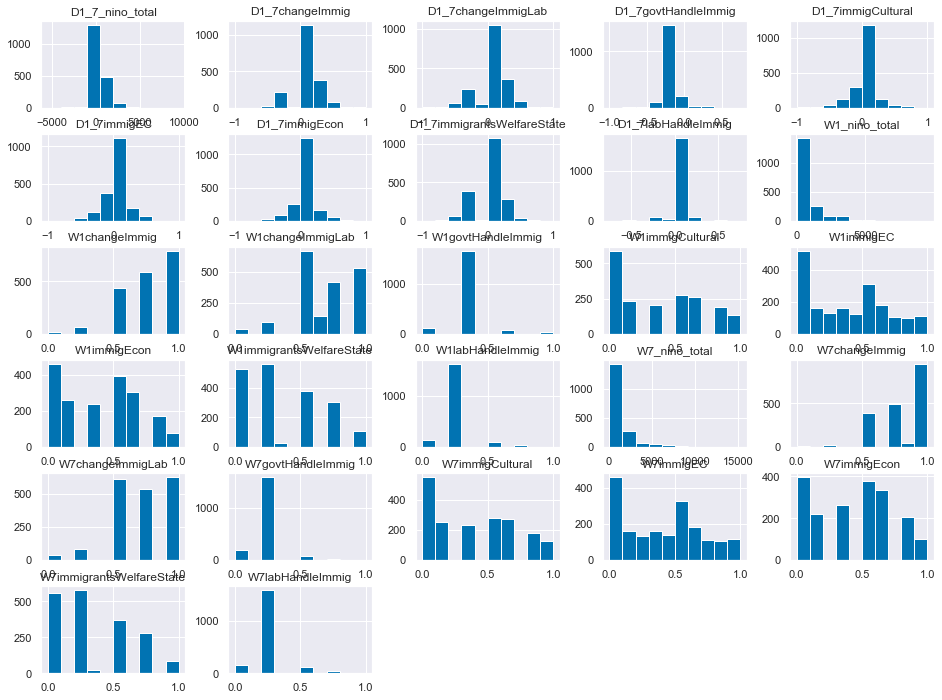

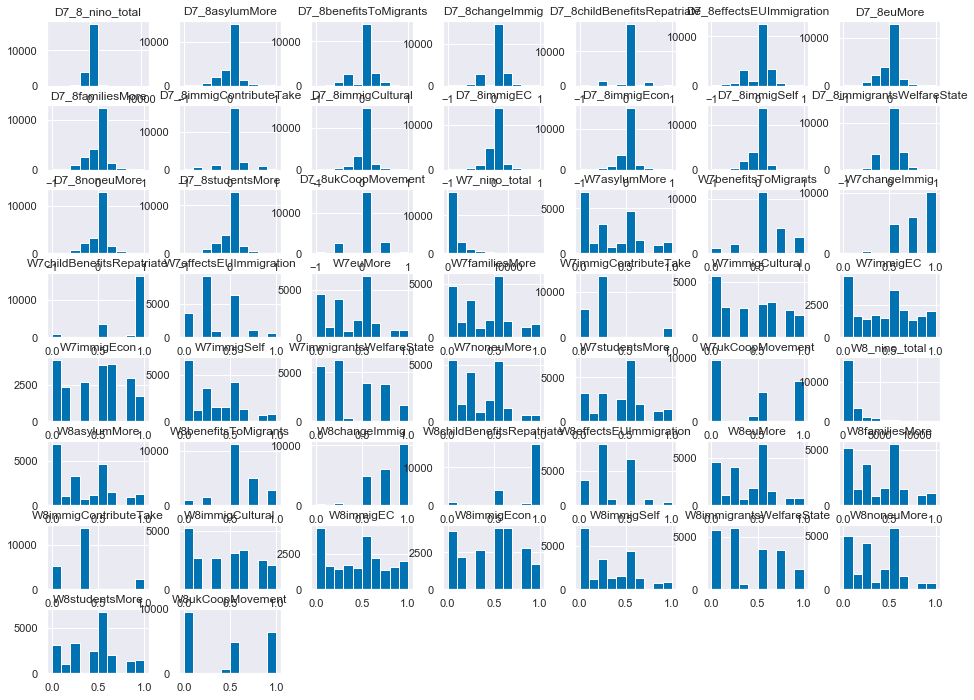

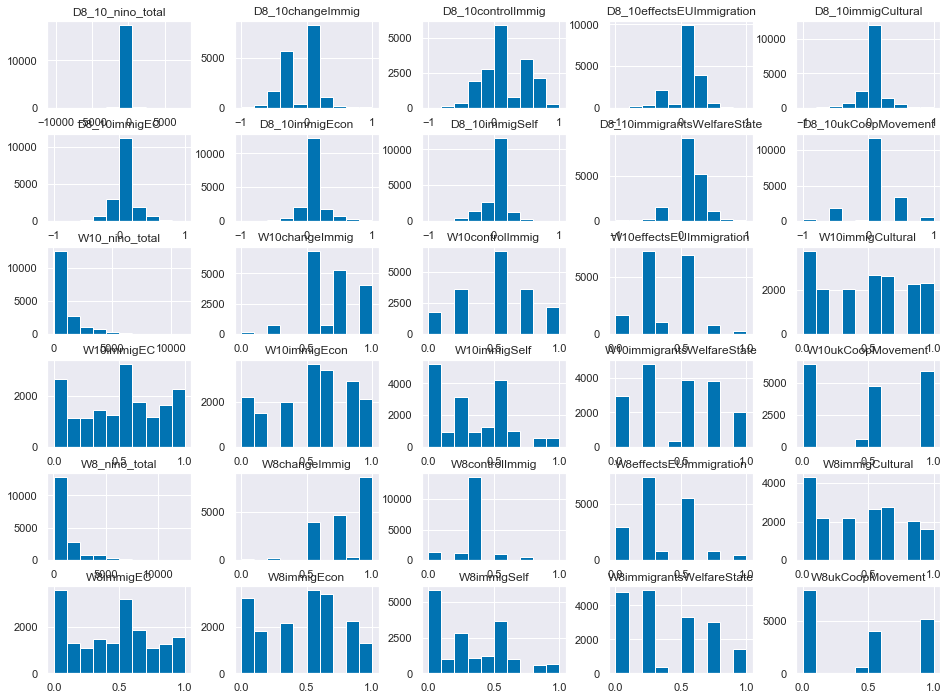

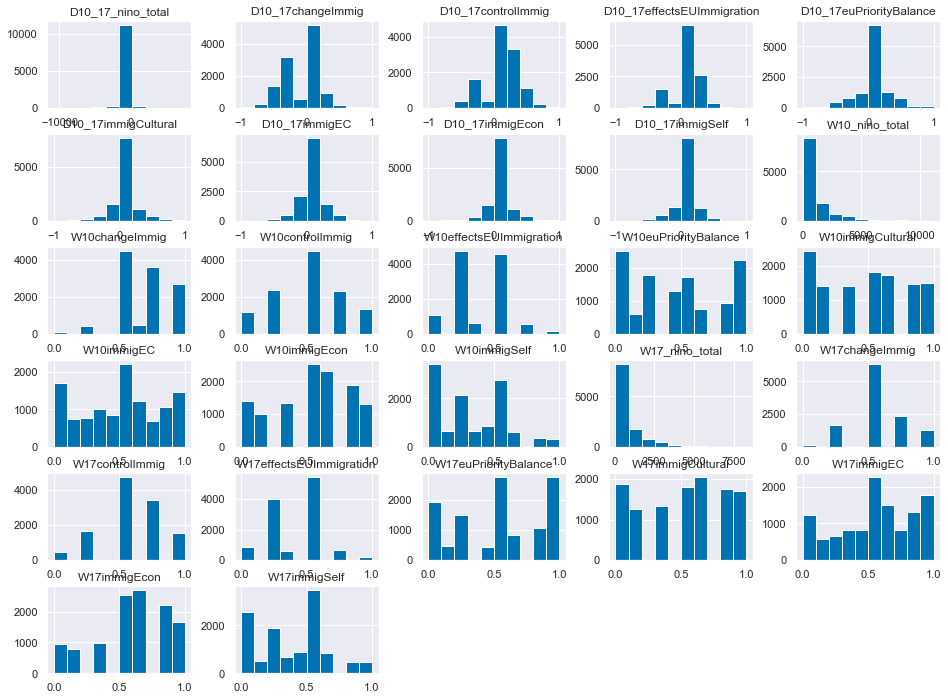

In [247]:
# wave_pair = wave_pairs[2]
for wave_pair in wave_pairs:

    first_wave = wave_pair[0]
    second_wave = wave_pair[1]

    var_set = immig_var_stub
    #["immigSelf","immigEcon","immigCultural","changeImmig","ukCoopMovement","effectsEUImmigration",            "immigrantsWelfareState",]

    target_vars = search(BES_Panel,"immig(Econ|Cultural)("+first_wave+"|"+second_wave+")").index
    mask = BES_Panel[target_vars].applymap(lambda x: pd.notnull(x) and (x!="Don't know")).all(axis=1)



    var_present_subset = [x for x in immig_var_stub if (x+first_wave in BES_Panel.columns) and (x+second_wave in BES_Panel.columns) ]


    df = BES_Panel[flatten([[x+y for y in [first_wave,second_wave]] for x in var_present_subset])][mask].apply(lambda x: x.replace("Don't know", np.nan).cat.codes.replace(-1,np.nan))

    df.columns = [re.search("W\d+$",x).group()+x.replace(re.search("W\d+$",x).group(),"") for x in df.columns]
    econ_cult_df = pd.DataFrame( (df[[x for x in df.columns if "immigEcon" in x]].values + df[[x for x in df.columns if "immigCultural" in x]].values)/2,
                 index = df.index, columns=[x.replace("Econ","EC") for x in df.columns if "immigEcon" in x])
    df[econ_cult_df.columns] = econ_cult_df

    var_present_subset.append("immigEC")


    df_missing_vals = df.isnull().copy()
    # ugly mean imputation
    df.fillna(df.mean(),inplace=True)


    normed_df = (df[df.notnull().all(axis=1)]/df[df.notnull().all(axis=1)].max())


    delta_substr = "D"+first_wave.replace("W","")+"_"+second_wave.replace("W","")

    delta_df = pd.DataFrame(normed_df[[second_wave+x for x in var_present_subset]].values-normed_df[[first_wave+x for x in var_present_subset]].values,
                columns = [delta_substr+x for x in var_present_subset],index=normed_df.index)
    normed_df[delta_df.columns] = delta_df

    # econ_cult_df = pd.DataFrame( (normed_df[[x for x in normed_df.columns if "immigEcon" in x]].values + normed_df[[x for x in normed_df.columns if "immigCultural" in x]].values)/2,
    #              index = normed_df.index, columns=[x.replace("Econ","EC") for x in normed_df.columns if "immigEcon" in x])
    # normed_df[econ_cult_df.columns] = econ_cult_df
    
#     normed_df.index
    normed_df[first_wave+"_nino_total"] = nino_df.loc[normed_df.index,first_wave+"_nino"]
    normed_df[second_wave+"_nino_total"] = nino_df.loc[normed_df.index,second_wave+"_nino"]
    normed_df[delta_substr+"_nino_total"] = normed_df[second_wave+"_nino_total"] - normed_df[first_wave+"_nino_total"]

    normed_df.hist(bins=10,figsize=(16,12));
    display(normed_df.describe())
    df_missing_vals.to_stata(BES_data_folder+"Portes"+os.sep+"missing&DK_values_"+first_wave+"_"+second_wave+".dta")
    normed_df.to_stata(BES_data_folder+"Portes"+os.sep+"test_dataset_"+first_wave+"_"+second_wave+".dta")

In [ ]:
## Maybe I should build a function to convert to STATA column names?

In [134]:
normed_df

,W8immigSelf,W10immigSelf,W8immigEcon,W10immigEcon,W8immigCultural,W10immigCultural,W8changeImmig,W10changeImmig,W8ukCoopMovement,W10ukCoopMovement,...,D8_10immigSelf,D8_10immigEcon,D8_10immigCultural,D8_10changeImmig,D8_10ukCoopMovement,D8_10effectsEUImmigration,D8_10immigrantsWelfareState,W8immigEcon&Cult,W10immigEcon&Cult,D8_10immigEcon&Cult
1,0.4,0.4,0.500000,0.666667,0.666667,0.666667,1.00,0.75,0.0,0.5,...,0.0,0.166667,0.000000,-0.25,0.5,0.25,0.25,0.583333,0.666667,8.333333e-02
6,0.0,0.0,0.833333,0.166667,0.166667,0.000000,1.00,0.75,0.0,0.0,...,0.0,-0.666667,-0.166667,-0.25,0.0,0.25,0.00,0.500000,0.083333,-4.166667e-01
10,0.4,0.3,0.166667,0.666667,0.000000,0.666667,1.00,0.50,0.0,0.5,...,-0.1,0.500000,0.666667,-0.50,0.5,0.00,0.25,0.083333,0.666667,5.833333e-01
14,0.0,0.5,0.666667,0.500000,0.333333,0.500000,1.00,0.50,0.5,1.0,...,0.5,-0.166667,0.166667,-0.50,0.5,0.00,0.75,0.500000,0.500000,2.775558e-17
16,0.0,0.0,0.166667,0.000000,0.000000,0.000000,1.00,1.00,0.0,0.0,...,0.0,-0.166667,0.000000,0.00,0.0,0.00,0.25,0.083333,0.000000,-8.333333e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56612,0.9,1.0,1.000000,0.666667,0.666667,0.833333,1.00,0.75,1.0,0.5,...,0.1,-0.333333,0.166667,-0.25,-0.5,0.00,0.00,0.833333,0.750000,-8.333333e-02
56616,0.2,0.3,0.333333,0.500000,0.500000,0.166667,1.00,0.75,0.0,1.0,...,0.1,0.166667,-0.333333,-0.25,1.0,0.25,0.00,0.416667,0.333333,-8.333333e-02
56620,0.0,0.1,0.166667,0.500000,0.166667,0.166667,1.00,0.75,0.5,0.0,...,0.1,0.333333,0.000000,-0.25,-0.5,0.25,0.50,0.166667,0.333333,1.666667e-01
56621,0.8,1.0,0.833333,1.000000,0.833333,1.000000,0.75,0.50,1.0,1.0,...,0.2,0.166667,0.166667,-0.25,0.0,0.25,0.25,0.833333,1.000000,1.666667e-01


In [91]:
normed_df

,W8immigEcon,W10immigEcon,W8immigCultural,W10immigCultural,W8immigSelf,W10immigSelf,W8immigrantsWelfareState,W10immigrantsWelfareState,W8controlImmig,W10controlImmig,...,W10immigEC,D8_10immigEcon,D8_10immigCultural,D8_10immigSelf,D8_10immigrantsWelfareState,D8_10controlImmig,D8_10effectsEUImmigration,D8_10changeImmig,D8_10ukCoopMovement,D8_10immigEC
0,0.000000,0.000000,0.000000,0.000000,0.0,0.316033,0.3768,0.00,0.311772,0.510221,...,0.000000,0.000000,0.000000,0.316033,-0.3768,0.198449,0.030839,-0.318254,0.064048,0.000000
1,0.333333,0.333333,0.333333,0.333333,0.1,0.300000,0.2500,0.50,0.750000,0.500000,...,0.333333,0.000000,0.000000,0.200000,0.2500,-0.250000,0.500000,0.250000,0.000000,0.000000
3,0.666667,0.666667,0.666667,0.666667,0.6,0.500000,0.7500,0.50,0.311772,0.500000,...,0.666667,0.000000,0.000000,-0.100000,-0.2500,0.188228,0.000000,0.000000,0.000000,0.000000
6,0.500000,0.500000,0.333333,0.333333,0.3,0.200000,0.2500,0.00,0.311772,0.000000,...,0.416667,0.000000,0.000000,-0.100000,-0.2500,-0.311772,0.250000,-0.250000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.00,0.311772,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.188228,0.250000,0.000000,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97124,1.000000,0.500000,1.000000,0.666667,0.3,0.100000,0.2500,0.25,0.311772,0.250000,...,0.583333,-0.500000,-0.333333,-0.200000,0.0000,-0.061772,0.250000,0.000000,-0.500000,-0.416667
97128,0.500000,0.500000,0.500000,0.500000,0.4,0.400000,0.2500,0.75,0.750000,0.250000,...,0.500000,0.000000,0.000000,0.000000,0.5000,-0.500000,-0.250000,-0.250000,0.000000,0.000000
97142,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.00,0.311772,0.510221,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.198449,0.000000,0.000000,0.000000,0.000000
97146,0.166667,0.000000,0.000000,0.333333,0.0,0.000000,0.0000,0.00,0.311772,0.250000,...,0.166667,-0.166667,0.333333,0.000000,0.0000,-0.061772,1.000000,0.000000,0.000000,0.083333


In [112]:
normed_df.corr()

,immigSelfW8,immigSelfW10,immigEconW8,immigEconW10,immigCulturalW8,immigCulturalW10,changeImmigW8,changeImmigW10,ukCoopMovementW8,ukCoopMovementW10,...,immigSelf(W8->W10),immigEcon(W8->W10),immigCultural(W8->W10),changeImmig(W8->W10),ukCoopMovement(W8->W10),effectsEUImmigration(W8->W10),immigrantsWelfareState(W8->W10),immigEcon&CultW8,immigEcon&CultW10,immigEcon&Cult(W8->W10)
immigSelfW8,1.000000,0.797037,0.746555,0.675372,0.753577,0.712481,-0.595581,-0.425117,0.680367,0.629657,...,-0.360912,-0.115484,-0.029070,0.165461,-0.071398,-0.068615,-0.114646,0.790834,0.736712,-0.086769
immigSelfW10,0.797037,1.000000,0.725013,0.728170,0.735975,0.765456,-0.574938,-0.455591,0.667309,0.671455,...,0.275565,-0.006006,0.084330,0.117301,-0.001531,-0.027944,-0.043532,0.770276,0.792781,0.047615
immigEconW8,0.746555,0.725013,1.000000,0.770461,0.799455,0.716389,-0.555853,-0.409610,0.675776,0.611240,...,-0.068722,-0.351739,-0.094744,0.142365,-0.088926,-0.063420,-0.095627,0.944716,0.786474,-0.268046
immigEconW10,0.675372,0.728170,0.770461,1.000000,0.701718,0.779069,-0.505540,-0.427743,0.622359,0.644985,...,0.049456,0.325749,0.160137,0.077669,0.022419,-0.017938,0.008082,0.774681,0.936402,0.292201
immigCulturalW8,0.753577,0.735975,0.799455,0.701718,1.000000,0.803728,-0.561455,-0.418941,0.665181,0.616707,...,-0.062971,-0.155254,-0.268073,0.138917,-0.068401,-0.057201,-0.076576,0.952230,0.800969,-0.255705
immigCulturalW10,0.712481,0.765456,0.716389,0.779069,0.803728,1.000000,-0.544889,-0.448503,0.647127,0.658853,...,0.047967,0.081524,0.357762,0.095476,0.008311,-0.026952,-0.008732,0.802873,0.949533,0.266042
changeImmigW8,-0.595581,-0.574938,-0.555853,-0.505540,-0.561455,-0.544889,1.000000,0.437811,-0.559461,-0.503456,...,0.060163,0.082040,-0.001096,-0.536796,0.076897,0.061622,0.109167,-0.589026,-0.557933,0.048435
changeImmigW10,-0.425117,-0.455591,-0.409610,-0.427743,-0.418941,-0.448503,0.437811,1.000000,-0.387714,-0.403020,...,-0.026868,-0.020614,-0.068698,0.523538,-0.015505,0.072992,0.003717,-0.436895,-0.465057,-0.054054
ukCoopMovementW8,0.680367,0.667309,0.675776,0.622359,0.665181,0.647127,-0.559461,-0.387714,1.000000,0.693082,...,-0.052478,-0.088359,0.003843,0.166331,-0.400349,-0.055699,-0.096804,0.706605,0.673607,-0.050548
ukCoopMovementW10,0.629657,0.671455,0.611240,0.644985,0.616707,0.658853,-0.503456,-0.403020,0.693082,1.000000,...,0.034641,0.040578,0.098908,0.098894,0.383093,-0.021923,-0.019899,0.647340,0.691491,0.084347


In [81]:
search(BES_Panel,"pcon")

mapConW3              15154
leaveVoteUKIPConW7     7682
leaveVoteUKIPConW8     6106
pContactEday_10W13    14112
pContactEday_1W13     10236
pContactEday_2W13     10957
pContactEday_3W13      6673
pContactEday_4W13      2271
pContactEday_5W13      1344
pContactEday_6W13      2302
pContactEday_9W13      2449
pContactEday_7W13      1092
pContactEday_99W13    14112
pContactEday_10W19    14555
pContactEday_1W19     10192
pContactEday_2W19     10917
pContactEday_3W19      8011
pContactEday_4W19      1797
pContactEday_5W19      1013
pContactEday_6W19       903
pContactEday_9W19      2747
pContactEday_12W19     3808
pContactEday_7W19       710
pContactEday_13W19     1007
pContactEday_99W19    14555
pconW17               34366
pconW1                30385
pconW2                30469
pconW3                27053
pconW5                31045
pconW6                29453
pconW7                32266
pconW8                33558
pconW9                30192
pconW10               32844
pconW11             

In [60]:
BES_Panel["profile_ethnicity"].value_counts()

White British                 62382
Any other white background     3189
Prefer not to say               861
Indian                          657
Other ethnic group              449
Pakistani                       348
Chinese                         346
Any other mixed background      346
White and Asian                 345
Black African                   338
Black Caribbean                 239
Any other Asian background      222
White and Black Caribbean       217
Bangladeshi                     166
White and Black African         122
Any other black background       63
Name: profile_ethnicity, dtype: int64

In [80]:
BES_Panel["pcon"]

KeyError: 'pcon'

In [ ]:
# demographic

# gender
# education

# ethnicity
# age

# income

# 

# geography

    # region
    # urban/rural?? Centre for Cities nomenclature??
    # check people who move???

In [66]:
BES_Panel["profile_gross_household"]

0          Â£5,000 to Â£9,999 per year
1        Â£30,000 to Â£34,999 per year
2        Â£15,000 to Â£19,999 per year
3        Â£35,000 to Â£39,999 per year
4                                  NaN
                     ...              
97153    Â£25,000 to Â£29,999 per year
97154    Â£70,000 to Â£99,999 per year
97155                              NaN
97156    Â£20,000 to Â£24,999 per year
97157                              NaN
Name: profile_gross_household, Length: 97158, dtype: category
Categories (17, object): [under Â£5,000 per year < Â£5,000 to Â£9,999 per year < Â£10,000 to Â£14,999 per year < Â£15,000 to Â£19,999 per year ... Â£100,000 to Â£149,999 per year < Â£150,000 and over < Prefer not to answer < Don't know]

In [101]:
search(BES_Panel, "countryW\d+")

automationEffectsCountryW16     9330
countryW1                      30382
countryW2                      30467
countryW3                      27052
countryW5                      31039
countryW6                      29446
countryW7                      32251
countryW8                      33505
countryW9                      30173
countryW10                     32830
countryW11                     33374
countryW12                     36948
countryW13                     33140
countryW14                     32697
countryW15                     31028
countryW16                     39471
countryW17                     34366
countryW19                     32205
dtype: int64

In [78]:
search(BES_Panel, "profile").sort_values(ascending=False).head(19).index

Index(['profile_oslaua', 'profile_eurefturnout', 'profile_turnout_2015',
       'profile_past_vote_2015', 'profile_turnout_2017', 'profile_ethnicity',
       'profile_eurefvote', 'profile_past_vote_2010', 'profile_past_vote_2017',
       'profile_newspaper', 'profile_household_children',
       'profile_past_vote_2005', 'profile_house_tenure', 'profile_religion',
       'profile_lea', 'profile_household_size', 'profile_gross_household',
       'profile_gross_personal', 'profile_education_age'],
      dtype='object')

In [62]:
list( search(BES_Panel, "profile").index )

['profile_work_organisationW1_W3',
 'profile_mpnameW2',
 'profile_mpnameW3',
 'profile_education_ageW7',
 'profile_ethnicityW7',
 'profile_gross_householdW7',
 'profile_gross_personalW7',
 'profile_household_sizeW7',
 'profile_leaW7',
 'profile_socgradeW7',
 'profile_work_statW7',
 'profile_work_typeW7W10',
 'profile_socgradeW8',
 'profile_newspaperW10',
 'profile_religionW10',
 'profile_sexualityW10',
 'profile_house_tenureW10',
 'profile_household_sizeW10',
 'profile_gross_householdW10',
 'profile_gross_householdW11',
 'profile_marital_statW11',
 'profile_work_statW11',
 'profile_work_typeW11',
 'profile_house_tenureW11',
 'profile_newspaperW11',
 'profile_religionW11',
 'profile_newspaper2W12',
 'profile_gross_householdW12',
 'profile_socgradeW12',
 'profile_work_statW12',
 'profile_house_tenureW12',
 'profile_religionW12',
 'profile_education_ageW13',
 'profile_gross_householdW13',
 'profile_marital_statW13',
 'profile_newspaperW13',
 'profile_socgradeW13',
 'profile_work_statW13',
 'profile_house_tenureW13',
 'profile_religionW13',
 'profile_gross_householdW14',
 'profile_marital_statW14',
 'profile_socgradeW14',
 'profile_work_industryW14',
 'profile_work_organisationW14',
 'profile_work_responsibilityW14',
 'profile_work_statW14',
 'profile_work_typeW14',
 'profile_religionW14',
 'profile_gross_householdW15',
 'profile_religionW15',
 'profiles_newspaper2W16',
 'profiles_newspaper2W17',
 'profile_scotRefW17',
 'profile_gross_householdW17',
 'profile_marital_statW17',
 'profile_socialgrade_cieW17',
 'profile_work_industryW17',
 'profile_work_organisationW17',
 'profile_work_responsibilityW17',
 'profile_work_statW17',
 'profile_work_typeW17',
 'profile_house_tenureW17',
 'profile_religionW17',
 'profile_ethnicity2W17',
 'profile_scotRefW18',
 'profile_education_ageW18',
 'profile_gross_householdW18',
 'profile_gross_personalW18',
 'profile_household_childrenW18',
 'profile_marital_statW18',
 'profile_household_sizeW18',
 'profile_socialgrade_cieW18',
 'profile_work_industryW18',
 'profile_work_organisationW18',
 'profile_work_responsibilityW18',
 'profile_work_statW18',
 'profile_work_typeW18',
 'profile_ethnicity2W18',
 'profile_scotRefW19',
 'profile_education_ageW19',
 'profile_gross_householdW19',
 'profile_gross_personalW19',
 'profile_household_childrenW19',
 'profile_household_sizeW19',
 'profile_socialgrade_cieW19',
 'profile_work_industryW19',
 'profile_work_organisationW19',
 'profile_work_responsibilityW19',
 'profile_work_statW19',
 'profile_work_typeW19',
 'profile_ethnicity2W19',
 'profile_education_age',
 'profile_ethnicity',
 'profile_lea',
 'profile_oslaua',
 'profile_gross_household',
 'profile_gross_personal',
 'profile_household_size',
 'profile_household_children',
 'profile_newspaper',
 'profile_past_vote_2005',
 'profile_past_vote_2010',
 'profile_religion',
 'profile_work_typeW2_W4',
 'profile_house_tenure',
 'profile_work_statW1_W10',
 'profile_house_tenureW14',
 'profile_socgradeW15',
 'profile_house_tenureW15',
 'profile_marital_statW15',
 'profile_house_tenureW16',
 'profile_marital_statW16',
 'profile_socgradeW16',
 'profile_gross_householdW16',
 'profile_religionW16',
 'profile_past_vote_2017',
 'profile_turnout_2017',
 'profile_past_vote_2015',
 'profile_turnout_2015',
 'profile_eurefvote',
 'profile_eurefturnout',
 'profile_scotref_turnout',
 'profile_scotref_vote']

In [98]:
BES_Panel["country"].value_counts()

KeyError: 'country'

In [96]:
BES_Panel["profile_house_tenure"].value_counts().sum()

56443

In [74]:
demog_vars = ["profile_ethnicity","gender","profile_gross_household","profile_gross_personal","profile_house_tenure",
             "profile_household_size","profile_newspaper"]


In [109]:
demog_vars = ["id",'profile_oslaua', 'profile_eurefturnout', 'profile_turnout_2015',
       'profile_past_vote_2015', 'profile_turnout_2017', 'profile_ethnicity',
       'profile_eurefvote', 'profile_past_vote_2010', 'profile_past_vote_2017',
       'profile_newspaper', 'profile_household_children',
       'profile_past_vote_2005', 'profile_house_tenure', 'profile_religion',
       'profile_lea', 'profile_household_size', 'profile_gross_household',
       'profile_gross_personal', 'profile_education_age']

demog_vars.append("gender")
demog_vars.append("marital")
demog_vars.append("euRefLA")
demog_vars.append("disability")
demog_vars.append("Age")
demog_vars.append("ageGroup")
demog_vars.append("countryOfBirth")
df = BES_Panel[demog_vars].copy()
df["id"] = df["id"].astype("int32")
df["Age"] = df["Age"].astype("float")

df.to_stata(BES_data_folder+"Portes"+os.sep+"cross_wave_demographic_variables"+".dta")

In [ ]:
# pcon/pano/gor/country need to be tracked per wave, handle transitions
# anyUni/edlevel
# subjClass
# workingStatusW19

In [89]:
cols = BES_Panel.columns
wave_cols = search(BES_Panel, "W\d+").index

In [90]:
set(cols) - set(wave_cols)

{'Age',
 'ageGroup',
 'countryOfBirth',
 'disability',
 'euRefLA',
 'fatherNumEmployees',
 'gender',
 'headHouseholdPast',
 'housing',
 'id',
 'marital',
 'motherNumEmployees',
 'profile_education_age',
 'profile_ethnicity',
 'profile_eurefturnout',
 'profile_eurefvote',
 'profile_gross_household',
 'profile_gross_personal',
 'profile_house_tenure',
 'profile_household_children',
 'profile_household_size',
 'profile_lea',
 'profile_newspaper',
 'profile_oslaua',
 'profile_past_vote_2005',
 'profile_past_vote_2010',
 'profile_past_vote_2015',
 'profile_past_vote_2017',
 'profile_religion',
 'profile_scotref_turnout',
 'profile_scotref_vote',
 'profile_turnout_2015',
 'profile_turnout_2017',
 'voted2015',
 'wave1',
 'wave10',
 'wave11',
 'wave12',
 'wave13',
 'wave14',
 'wave15',
 'wave16',
 'wave17',
 'wave18',
 'wave19',
 'wave2',
 'wave3',
 'wave4',
 'wave5',
 'wave6',
 'wave7',
 'wave8',
 'wave9'}

In [16]:
sorted(wave_nos)

[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]

In [24]:
wave_nos = [int(x.replace("pconW","")) for x in match( BES_Panel, "pconW\d+").sort_index().index]
wave_nos = sorted(wave_nos)

diffs = BES_Panel[["pconW"+str(x) for x in wave_nos]].apply(lambda x: x.cat.codes).replace(-1,np.nan).diff(axis=1)
diffs.stack().value_counts()
# 1/-1 -> means the categories are not constant! -> Fixed/use raw values not cat codes

 0.0      336451
 1.0       22109
-1.0       21347
-2.0         115
 2.0         111
           ...  
 587.0         1
 520.0         1
 576.0         1
 396.0         1
 494.0         1
Length: 1062, dtype: int64

In [23]:
BES_Panel[["pconW"+str(x) for x in wave_nos]]

,pconW1,pconW2,pconW3,pconW5,pconW6,pconW7,pconW8,pconW9,pconW10,pconW11,pconW12,pconW13,pconW14,pconW15,pconW16,pconW17,pconW19
0,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon
1,Aberavon,Aberavon,Aberavon,Aberavon,NaN,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,NaN,Aberavon
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon
3,NaN,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aberavon,Aberavon,Aberavon,Aberavon,Aberavon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97153,North West Norfolk,North West Norfolk,Ealing Central and Acton,Ealing Central and Acton,Ealing Central and Acton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97154,NaN,NaN,NaN,Reigate,Reigate,Reigate,Reigate,Reigate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97155,NaN,NaN,NaN,NaN,NaN,NaN,Hendon,NaN,NaN,NaN,NaN,NaN,Hendon,Hendon,NaN,NaN,NaN
97156,Eastbourne,Eastbourne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
diffs

,pconW1,pconW2,pconW3,pconW5,pconW6,pconW7,pconW8,pconW9,pconW10,pconW11,pconW12,pconW13,pconW14,pconW15,pconW16,pconW17,pconW19
0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
1,NaN,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
3,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97153,NaN,0.0,-185.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97154,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
97156,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
BES_Panel[[ "pconW"+str(x) for x in wave_nos[0:-1] ]].eq( BES_Panel[[ "pconW"+str(x) for x in wave_nos[1:] ]] )

,pconW1,pconW10,pconW11,pconW12,pconW13,pconW14,pconW15,pconW16,pconW17,pconW19,pconW2,pconW3,pconW5,pconW6,pconW7,pconW8,pconW9
0,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True
1,False,True,True,True,True,True,True,True,False,False,True,True,True,False,True,True,True
2,False,False,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False
3,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True
4,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97153,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False
97154,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
97155,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False
97156,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [31]:
df = BES_Panel[[ "pconW"+str(x) for x in wave_nos ]].copy()
df = df.fillna(axis=1,method='ffill').fillna(axis=1,method='bfill')

In [50]:
period=2

pd.DataFrame(df[[ "pconW"+str(x) for x in wave_nos[0:-period] ]].values == df[[ "pconW"+str(x) for x in wave_nos[period:] ]].values,
             columns=[str(wave_nos[x])+"->"+str(wave_nos[x+period]) for x in range(len(wave_nos)-period)]).sum()/df.shape[0]

1->3      0.985784
2->5      0.976105
3->6      0.978889
5->7      0.980120
6->8      0.979557
7->9      0.988245
8->10     0.984104
9->11     0.978900
10->12    0.979661
11->13    0.985732
12->14    0.979359
13->15    0.970097
14->16    0.976178
15->17    0.976334
16->19    0.975166
dtype: float64

95876

In [36]:
wave_nos[0:-1]

[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [37]:
wave_nos[1:]

[2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]

In [7]:
var_name = "pano"

wave_nos = [int(x.replace(var_name+"W","")) for x in match( BES_Panel, var_name+"W\d+").sort_index().index]
wave_nos = sorted(wave_nos)
wave_nos

[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]

In [ ]:
# save wave nos for pcon/pano -> lets check if the nulls are the same

In [13]:
pcon_pano_non_nulls_nonmatch = pd.DataFrame(BES_Panel[["pconW"+str(x) for x in wave_nos]].notnull().values != BES_Panel[["panoW"+str(x) for x in wave_nos]].notnull().values,
             columns = wave_nos)

In [14]:
pcon_pano_non_nulls_nonmatch.sum()

1      1
2      2
3      1
5      4
6      5
7     15
8     52
9     18
10    14
11    12
12    33
13    28
14     0
15     0
16     0
17     0
19     0
dtype: int64

In [18]:
pano_2_pcon = pd.read_csv(BES_small_data_files + "pano_pcon_ons.csv", encoding=encoding)

In [20]:
search(BES_Panel,"wave")

wave1     95876
wave2     95876
wave3     95876
wave4     95876
wave5     95876
wave6     95876
wave7     95876
wave8     95876
wave9     95876
wave10    95876
wave11    95876
wave12    95876
wave13    95876
wave14    95876
wave15    95876
wave16    95876
wave17    95876
wave18    95876
wave19    95876
dtype: int64

In [25]:
for wno in wave_nos:
    display( match(BES_Panel,"pconW"+str(wno)+"$",mask=BES_Panel["wave"+str(wno)]==True)/BES_Panel["wave"+str(wno)].sum() )

pconW1    1.0
dtype: float64

pconW2    1.0
dtype: float64

pconW3    0.96181
dtype: float64

pconW5    0.999967
dtype: float64

pconW6    0.949763
dtype: float64

pconW7    0.998798
dtype: float64

pconW8    1.0
dtype: float64

pconW9    1.0
dtype: float64

pconW10    0.999967
dtype: float64

pconW11    1.0
dtype: float64

pconW12    1.0
dtype: float64

pconW13    0.995143
dtype: float64

pconW14    1.0
dtype: float64

pconW15    1.0
dtype: float64

pconW16    1.0
dtype: float64

pconW17    1.0
dtype: float64

pconW19    1.0
dtype: float64

In [26]:
for wno in wave_nos:
    display( match(BES_Panel,"panoW"+str(wno)+"$",mask=BES_Panel["wave"+str(wno)]==True)/BES_Panel["wave"+str(wno)].sum() )

panoW1    0.999967
dtype: float64

panoW2    0.999967
dtype: float64

panoW3    0.961774
dtype: float64

panoW5    0.999869
dtype: float64

panoW6    0.949763
dtype: float64

panoW7    0.998766
dtype: float64

panoW8    0.998534
dtype: float64

panoW9    0.9994
dtype: float64

panoW10    0.999967
dtype: float64

panoW11    0.999968
dtype: float64

panoW12    0.999971
dtype: float64

panoW13    0.995143
dtype: float64

panoW14    1.0
dtype: float64

panoW15    1.0
dtype: float64

panoW16    1.0
dtype: float64

panoW17    1.0
dtype: float64

panoW19    1.0
dtype: float64

In [ ]:
# pcon has less missing values than pano, so lets stick with pcon and focus on the waves we look like using (1/7/8/10/17)

# issues only in pconW7, pconW10

In [31]:
w7_pcon_mval_ids = BES_Panel.loc[(BES_Panel["pconW7"].isnull()) & (BES_Panel["wave7"]==True)].index

In [33]:
BES_Panel.loc[ w7_pcon_mval_ids , [ "pconW"+str(x) for x in wave_nos ]]

# just a huge wall of NaN - no imputation possible!

,pconW1,pconW2,pconW3,pconW5,pconW6,pconW7,pconW8,pconW9,pconW10,pconW11,pconW12,pconW13,pconW14,pconW15,pconW16,pconW17,pconW19
34331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
w10_pcon_mval_ids = BES_Panel.loc[(BES_Panel["pconW10"].isnull()) & (BES_Panel["wave10"]==True)].index
BES_Panel.loc[ w10_pcon_mval_ids , [ "pconW"+str(x) for x in wave_nos ]]


,pconW1,pconW2,pconW3,pconW5,pconW6,pconW7,pconW8,pconW9,pconW10,pconW11,pconW12,pconW13,pconW14,pconW15,pconW16,pconW17,pconW19
8826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Derby North,Derby North,Derby North,NaN,Derby North,Derby North,NaN,Derby North


In [38]:
# power of manual imputation!
BES_Panel.loc[ w10_pcon_mval_ids , [ "pconW"+str(x) for x in wave_nos ]] = "Derby North"

In [118]:
nino = pd.read_stata( BES_data_folder+os.sep+"Portes"+os.sep+"NINO Constituencies - Annual.dta" )
nino["constituency"]=nino["constituency"].replace('Ynys Môn','Ynys Mon')

In [44]:
nino_constituencies = nino["constituency"].unique()


In [65]:
pcon_constituencies

array(['Aberavon', 'Aberconwy', 'Aberdeen North', 'Aberdeen South',
       'West Aberdeenshire and Kincardine', 'Airdrie and Shotts',
       'Aldershot', 'Aldridge-Brownhills', 'Altrincham and Sale West',
       'Alyn and Deeside', 'Amber Valley', 'Angus', 'Arfon',
       'Argyll and Bute', 'Arundel and South Downs', 'Ashfield',
       'Ashford', 'Ashton-under-Lyne', 'Aylesbury',
       'Ayr, Carrick and Cumnock', 'Central Ayrshire',
       'North Ayrshire and Arran', 'Banbury', 'Banff and Buchan',
       'Barking', 'Barnsley Central', 'Barnsley East',
       'Barrow and Furness', 'Basildon and Billericay',
       'South Basildon and East Thurrock', 'Basingstoke', 'Bassetlaw',
       'Bath', 'Batley and Spen', 'Battersea', 'Beaconsfield',
       'Beckenham', 'Bedford', 'Mid Bedfordshire',
       'North East Bedfordshire', 'South West Bedfordshire',
       'Bermondsey and Old Southwark', 'Berwick-upon-Tweed',
       'Berwickshire, Roxburgh and Selkirk', 'Bethnal Green and Bow',
       '

In [66]:
pcon_constituencies = pd.Series(pano_2_pcon["constituency_name"].unique())

In [67]:
pcon_constituencies = pcon_constituencies.replace("Carmarthen West and Pembrokeshire South","Carmarthen West and South Pembrokeshire")
pcon_constituencies = pcon_constituencies.replace("Ynys Môn","Ynys Mon")

In [51]:
set(pcon_constituencies) - set(nino_constituencies)

# 19! - 18 constituencies in Northern Ireland! 

# one of these is not like the others

{'Belfast East',
 'Belfast North',
 'Belfast South',
 'Belfast West',
 'Carmarthen West and Pembrokeshire South',
 'East Antrim',
 'East Londonderry',
 'Fermanagh and South Tyrone',
 'Foyle',
 'Lagan Valley',
 'Mid Ulster',
 'Newry and Armagh',
 'North Antrim',
 'North Down',
 'South Antrim',
 'South Down',
 'Strangford',
 'Upper Bann',
 'West Tyrone'}

In [52]:
 set(nino_constituencies) - set(pcon_constituencies)
    
# nino: 'Carmarthen West and South Pembrokeshire' (wiki agrees!)
# pcon: 'Carmarthen West and Pembrokeshire South'

{'Carmarthen West and South Pembrokeshire'}

In [54]:
set(BES_Panel["pconW1"].cat.categories)  - set(pcon_constituencies)

{998.0, 'Carmarthen West and South Pembrokeshire', 'Ynys Mon'}

In [55]:
set(pcon_constituencies) - set(BES_Panel["pconW1"].cat.categories)

# change pcon_constituencies:
# 'Ynys Môn' -> 'Ynys Mon'
# 'Carmarthen West and Pembrokeshire South' -> Carmarthen West and South Pembrokeshire


# 998.0 -> missing value?

{'Belfast East',
 'Belfast North',
 'Belfast South',
 'Belfast West',
 'Carmarthen West and Pembrokeshire South',
 'East Antrim',
 'East Londonderry',
 'Fermanagh and South Tyrone',
 'Foyle',
 'Lagan Valley',
 'Mid Ulster',
 'Newry and Armagh',
 'North Antrim',
 'North Down',
 'South Antrim',
 'Strangford',
 'Upper Bann',
 'West Tyrone',
 'Ynys Môn'}

In [56]:
BES_Panel["pconW1"].value_counts()

Edinburgh North and Leith                 195
Cardiff North                             150
Edinburgh East                            147
Edinburgh South West                      144
Argyll and Bute                           141
                                         ... 
Sheffield, Brightside and Hillsborough     20
Birmingham, Hodge Hill                     13
Leicester East                             11
998.0                                       1
South Down                                  0
Name: pconW1, Length: 634, dtype: int64

In [57]:
BES_Panel.loc[ BES_Panel["pconW1"]==998.0 , [ "pconW"+str(x) for x in wave_nos ]]

,pconW1,pconW2,pconW3,pconW5,pconW6,pconW7,pconW8,pconW9,pconW10,pconW11,pconW12,pconW13,pconW14,pconW15,pconW16,pconW17,pconW19
96218,998,998,North Ayrshire and Arran,North Ayrshire and Arran,North Ayrshire and Arran,North Ayrshire and Arran,NaN,NaN,NaN,NaN,North Ayrshire and Arran,North Ayrshire and Arran,NaN,NaN,NaN,NaN,NaN


In [ ]:
# manual imputation!
BES_Panel.loc[ BES_Panel["pconW1"]==998.0 , [ "pconW"+str(x) for x in wave_nos ]] = "North Ayrshire and Arran"

In [59]:
set(pcon_constituencies) - set(BES_Panel["pconW7"].cat.categories)
# Ynys Mon, Carmarthen West and Pembrokeshire South
set(BES_Panel["pconW7"].cat.categories) - set(pcon_constituencies) 

{998.0,
 'Carmarthen West and South Pembrokeshire',
 'NOT in a 2010 Parliamentary Constituency',
 'Ynys Mon'}

In [60]:
BES_Panel.loc[ BES_Panel["pconW7"]==998.0 , [ "pconW"+str(x) for x in wave_nos ]]
# nothing to be done!

,pconW1,pconW2,pconW3,pconW5,pconW6,pconW7,pconW8,pconW9,pconW10,pconW11,pconW12,pconW13,pconW14,pconW15,pconW16,pconW17,pconW19
33275,NaN,NaN,NaN,NaN,NaN,998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
BES_Panel.loc[ BES_Panel["pconW7"]=='NOT in a 2010 Parliamentary Constituency' , [ "pconW"+str(x) for x in wave_nos ]]

# Too messy - just replace with nans and have half decent generic nan policy
# i.e. replace weight mean NINO levels

,pconW1,pconW2,pconW3,pconW5,pconW6,pconW7,pconW8,pconW9,pconW10,pconW11,pconW12,pconW13,pconW14,pconW15,pconW16,pconW17,pconW19
5889,NaN,Canterbury,NaN,Canterbury,NaN,NOT in a 2010 Parliamentary Constituency,NOT in a 2010 Parliamentary Constituency,NaN,Nottingham East,Canterbury,NaN,NaN,NaN,NaN,NaN,NaN,Canterbury
29006,NaN,NaN,NaN,Tynemouth,Tynemouth,NOT in a 2010 Parliamentary Constituency,Newcastle upon Tyne East,Newcastle upon Tyne East,NaN,NaN,NaN,NaN,NaN,North Tyneside,North Tyneside,NaN,North Tyneside
43004,NaN,NaN,Shrewsbury and Atcham,Shrewsbury and Atcham,Shrewsbury and Atcham,NOT in a 2010 Parliamentary Constituency,Shrewsbury and Atcham,NaN,Aldridge-Brownhills,NaN,NaN,Walsall North,Battersea,Walsall North,NaN,Walsall North,NaN
43290,Coventry South,Coventry South,Coventry South,Coventry South,Coventry South,NOT in a 2010 Parliamentary Constituency,NOT in a 2010 Parliamentary Constituency,NOT in a 2010 Parliamentary Constituency,NaN,NaN,NOT in a 2010 Parliamentary Constituency,NOT in a 2010 Parliamentary Constituency,NaN,NaN,NaN,NaN,NaN
45272,NaN,NaN,Twickenham,Twickenham,Twickenham,NOT in a 2010 Parliamentary Constituency,NaN,NaN,NaN,Twickenham,NaN,Twickenham,NaN,NaN,NaN,Twickenham,NaN
48880,NaN,NaN,NaN,Wirral West,Wirral West,NOT in a 2010 Parliamentary Constituency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59485,NaN,NaN,Walthamstow,Walthamstow,Walthamstow,NOT in a 2010 Parliamentary Constituency,NOT in a 2010 Parliamentary Constituency,Leyton and Wanstead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63139,NaN,NaN,NaN,Winchester,Winchester,NOT in a 2010 Parliamentary Constituency,NaN,NaN,NaN,Hertsmere,Hertsmere,NaN,NaN,NaN,NaN,NaN,NaN
67174,NaN,NaN,NaN,Derby North,Derby North,NOT in a 2010 Parliamentary Constituency,Harrogate and Knaresborough,Harrogate and Knaresborough,NaN,Newcastle upon Tyne North,NaN,Newcastle upon Tyne North,NaN,NaN,NaN,NaN,NaN
74002,NaN,NaN,Castle Point,Castle Point,NaN,NOT in a 2010 Parliamentary Constituency,Castle Point,Castle Point,NaN,NaN,NaN,NaN,Rayleigh and Wickford,NaN,NaN,NaN,NaN


In [69]:
set(BES_Panel["pconW10"].cat.categories) - set(pcon_constituencies)


{998.0, 'NOT in a 2010 Parliamentary Constituency'}

In [70]:
BES_Panel.loc[ BES_Panel["pconW10"]==998.0 , [ "pconW"+str(x) for x in wave_nos ]]
# nothing to be done!

,pconW1,pconW2,pconW3,pconW5,pconW6,pconW7,pconW8,pconW9,pconW10,pconW11,pconW12,pconW13,pconW14,pconW15,pconW16,pconW17,pconW19
52828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,998,NaN,NaN,NaN,"Manchester, Gorton",NaN,NaN,NaN,NaN
66915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,998,998,Cities of London and Westminster,NaN,NaN,NaN,NaN,NaN,NaN
69956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,998,998,Bishop Auckland,Bishop Auckland,Bishop Auckland,Bishop Auckland,NaN,NaN,NaN


In [71]:
BES_Panel.loc[ 52828 , [ "pconW"+str(x) for x in wave_nos ]] = "Manchester, Gorton"
BES_Panel.loc[ 66915 , [ "pconW"+str(x) for x in wave_nos ]] = "Cities of London and Westminster"
BES_Panel.loc[ 69956 , [ "pconW"+str(x) for x in wave_nos ]] = "Bishop Auckland"

In [72]:
BES_Panel.loc[ BES_Panel["pconW10"]=='NOT in a 2010 Parliamentary Constituency' , [ "pconW"+str(x) for x in wave_nos ]]

# Too messy - just replace with nans and have half decent generic nan policy
# i.e. replace weight mean NINO levels

,pconW1,pconW2,pconW3,pconW5,pconW6,pconW7,pconW8,pconW9,pconW10,pconW11,pconW12,pconW13,pconW14,pconW15,pconW16,pconW17,pconW19
3579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT in a 2010 Parliamentary Constituency,NaN,Boston and Skegness,Boston and Skegness,Boston and Skegness,NaN,Boston and Skegness,Boston and Skegness,Boston and Skegness
5714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT in a 2010 Parliamentary Constituency,Cambridge,Cambridge,Cambridge,Cambridge,North West Cambridgeshire,North West Cambridgeshire,North West Cambridgeshire,North West Cambridgeshire
6491,NaN,NaN,NaN,NaN,NaN,NaN,Charnwood,Charnwood,NOT in a 2010 Parliamentary Constituency,Charnwood,Charnwood,Charnwood,Leicester South,Charnwood,Charnwood,Charnwood,Charnwood
7258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT in a 2010 Parliamentary Constituency,NaN,NaN,NaN,Cities of London and Westminster,Cities of London and Westminster,Cities of London and Westminster,NaN,Cities of London and Westminster
8584,NaN,NaN,NaN,NaN,NaN,NaN,Darlington,NaN,NOT in a 2010 Parliamentary Constituency,Darlington,NaN,Darlington,NaN,NaN,NaN,NaN,Darlington
12406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT in a 2010 Parliamentary Constituency,NaN,NaN,NaN,Filton and Bradley Stoke,Filton and Bradley Stoke,Filton and Bradley Stoke,Filton and Bradley Stoke,Filton and Bradley Stoke
26583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT in a 2010 Parliamentary Constituency,NaN,NaN,NaN,NaN,NaN,Stockton North,Stockton North,Stockton North
54788,Scarborough and Whitby,NaN,Great Grimsby,NOT in a 2010 Parliamentary Constituency,NOT in a 2010 Parliamentary Constituency,NaN,NOT in a 2010 Parliamentary Constituency,NOT in a 2010 Parliamentary Constituency,NOT in a 2010 Parliamentary Constituency,Great Grimsby,NaN,Great Grimsby,NaN,NaN,NaN,Scarborough and Whitby,NaN
71563,Finchley and Golders Green,NaN,NaN,Finchley and Golders Green,Finchley and Golders Green,NaN,NaN,NaN,NOT in a 2010 Parliamentary Constituency,Finchley and Golders Green,Finchley and Golders Green,NaN,NaN,NaN,Finchley and Golders Green,NaN,NaN
90777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT in a 2010 Parliamentary Constituency,Aylesbury,Aylesbury,Aylesbury,NaN,NaN,NaN,Chesham and Amersham,NaN


In [75]:
set(BES_Panel["pconW17"].cat.categories) - set(pcon_constituencies)
# clean!

set()

In [110]:
BES_Panel.loc[:, [ "pconW"+str(x) for x in wave_nos ]] = BES_Panel.loc[:, [ "pconW"+str(x) for x in wave_nos ]].replace(998.0,np.nan).replace('NOT in a 2010 Parliamentary Constituency',np.nan)

In [196]:
NI_constituencies = {'Belfast East',
 'Belfast North',
 'Belfast South',
 'Belfast West',
 'East Antrim',
 'East Londonderry',
 'Fermanagh and South Tyrone',
 'Foyle',
 'Lagan Valley',
 'Mid Ulster',
 'Newry and Armagh',
 'North Antrim',
 'North Down',
 'South Antrim',
 'South Down',
 'Strangford',
 'Upper Bann',
 'West Tyrone'}


replace_dict = dict( zip(NI_constituencies, [np.nan]*len(NI_constituencies)) )
replace_dict[998.0] = np.nan
replace_dict['NOT in a 2010 Parliamentary Constituency'] = np.nan

BES_Panel.loc[:, [ "pconW"+str(x) for x in wave_nos ]] = BES_Panel.loc[:, [ "pconW"+str(x) for x in wave_nos ]].replace(replace_dict)

In [81]:
nino["year"].unique()

array(['2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016',
       '2016-2017', '2017-2018'], dtype=object)

In [83]:
nino.describe()

,EU_reg,other_europe,asia,rest_world,other,total,postref,nonEU_reg,tot,EUpostref,EUprefre,dEU_reg,dnonEU_reg,dEUpostref
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,3792.000000,3792.000000,3792.000000
mean,780.740054,20.595615,160.718354,118.331148,0.644665,1083.091546,0.285714,300.289795,1081.029785,226.040237,-554.699829,21.626583,-8.499473,-48.603905
std,1096.590253,42.172748,272.580397,203.626811,3.017824,1493.196890,0.451805,467.131042,1493.533936,644.340454,1018.901978,384.127533,132.472504,165.767532
min,15.000000,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,20.000000,0.000000,-12498.000000,-2739.000000,-1970.000000,-2739.000000
25%,177.000000,0.000000,22.000000,21.000000,0.000000,245.000000,0.000000,46.000000,244.000000,0.000000,-613.000000,-62.000000,-29.000000,-16.250000
50%,395.000000,6.000000,56.000000,45.000000,0.000000,538.000000,0.000000,113.000000,535.500000,0.000000,-200.000000,-1.000000,-5.000000,0.000000
75%,894.250000,21.000000,180.000000,113.000000,0.000000,1227.250000,1.000000,331.000000,1225.250000,114.000000,0.000000,64.000000,15.000000,0.000000
max,12498.000000,560.000000,4214.000000,1800.000000,42.000000,15206.000000,1.000000,4829.000000,15196.000000,9071.000000,0.000000,5030.000000,1309.000000,590.000000


In [ ]:
# lets start by associating each side of the wave with a nino-year

# (maybe later split to EU/non-EU)

# Financial year I think (so 2017-18 is the total for  April 2017 to March 2018)

# W1 -> W7 2013, 2015
# W7 -> W8 2015, 2016
# W8 -> W10 2016, 2017
# W10 -> W17 2017, 2018

# Very iffy! (Best option would probably be to cover all combinations
#/ try to build a snice smooth spline at get the exact midpoint values)

In [91]:
wave_to_nino = {"W1":'2013-2014',"W7":"2014-2015","W8":"2015-2016","W10":"2016-2017","W17":"2017-2018"}

In [84]:
wave_to_date

Wave No
19    Dec-19
18    Nov-19
17    Nov-19
16    May-19
15    Mar-19
14    May-18
13    Jun-17
12    May-17
11    Apr-17
10    Nov-16
9     Jun-16
8     May-16
7     Apr-16
6     May-15
5     Mar-15
4     Mar-15
3     Sep-14
2     May-14
1     Feb-14
Name: Date_Start, dtype: object

In [85]:
nino

,id,year,constituency,EU_reg,other_europe,asia,rest_world,other,total,postref,nonEU_reg,tot,yearnum,con,EUpostref,EUprefre,dEU_reg,dnonEU_reg,dEUpostref
0,Aberavon2011-2012,2011-2012,Aberavon,37,0,42,7,0,95,0,49.0,86.0,2011-2012,Aberavon,0.0,-37.0,NaN,NaN,NaN
1,Aberavon2012-2013,2012-2013,Aberavon,32,0,34,0,0,79,0,34.0,66.0,2012-2013,Aberavon,0.0,-32.0,-5.0,-15.0,0.0
2,Aberavon2013-2014,2013-2014,Aberavon,40,0,24,0,0,69,0,24.0,64.0,2013-2014,Aberavon,0.0,-40.0,8.0,-10.0,0.0
3,Aberavon2014-2015,2014-2015,Aberavon,51,0,33,11,0,108,0,44.0,95.0,2014-2015,Aberavon,0.0,-51.0,11.0,20.0,0.0
4,Aberavon2015-2016,2015-2016,Aberavon,73,0,30,7,0,118,0,37.0,110.0,2015-2016,Aberavon,0.0,-73.0,22.0,-7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,York Outer2013-2014,2013-2014,York Outer,176,5,134,45,0,370,0,184.0,360.0,2013-2014,York Outer,0.0,-176.0,18.0,-24.0,0.0
4420,York Outer2014-2015,2014-2015,York Outer,275,28,175,64,0,540,0,267.0,542.0,2014-2015,York Outer,0.0,-275.0,99.0,83.0,0.0
4421,York Outer2015-2016,2015-2016,York Outer,198,6,160,47,0,416,0,213.0,411.0,2015-2016,York Outer,0.0,-198.0,-77.0,-54.0,0.0
4422,York Outer2016-2017,2016-2017,York Outer,217,5,107,49,0,388,1,161.0,378.0,2016-2017,York Outer,217.0,0.0,19.0,-52.0,19.0


In [234]:
# first_wave = "W1"
df = pd.DataFrame()
series_list = []
for first_wave in wave_to_nino.keys():

    temp = pd.Series( nino.set_index(["year","constituency"]).loc[[(wave_to_nino[first_wave],x) for x in BES_Panel["pcon"+first_wave][ BES_Panel["pcon"+first_wave].notnull()]]]["total"].values,
                       index = BES_Panel["pcon"+first_wave][ BES_Panel["pcon"+first_wave].notnull()].index,
                       name = first_wave+"_nino" )
#     df[temp.name] = temp
    ## weighted mean ideally
    mean_val = temp.mean()

    indices=  BES_Panel.index[ (BES_Panel["wave"+first_wave.replace("W","")]==True) & (BES_Panel["pcon"+first_wave].isnull())]
#    temp2 = pd.DataFrame([mean_val]*len(indices),index=indices, columns =[temp.name]  )
    temp = temp.append( pd.Series([np.nan]*len(indices),index = indices,) )
    temp.name =first_wave+"_nino"
    series_list.append(temp)
#     for ind in indices:
#         df.loc[ind,temp.name] = mean_val
# #     df = df.append(temp2)
# df
nino_df = pd.concat(series_list,axis=1)


In [211]:
df[temp.name].value_counts().sum()

8630

In [231]:
temp.name = first_wave+"_nino"

0         142
2         142
3         142
4         142
6         142
         ... 
97132     424
97136     646
97144     305
97151    1243
97157     277
Length: 34336, dtype: int32

In [212]:
BES_Panel["pcon"+first_wave][ BES_Panel["pcon"+first_wave].notnull()].index

Int64Index([    0,     2,     3,     4,     6,     7,     8,     9,    11,
               13,
            ...
            97086, 97104, 97122, 97124, 97127, 97132, 97136, 97144, 97151,
            97157],
           dtype='int64', length=34336)

In [189]:
BES_Panel["pcon"+first_wave][ BES_Panel["pcon"+first_wave].notnull()].

0                       Aberavon
1                       Aberavon
3                       Aberavon
6                       Aberavon
8                       Aberavon
                  ...           
97147                 Canterbury
97148                 Chippenham
97149             City of Durham
97150    Beverley and Holderness
97154                    Reigate
Name: pconW7, Length: 32152, dtype: category
Categories (635, object): [Aldershot < Aldridge-Brownhills < Altrincham and Sale West < Amber Valley ... West Dunbartonshire < Belfast South < North Antrim < South Antrim]

In [187]:
first_wave = "W7"
set(BES_Panel["pcon"+first_wave][ BES_Panel["pcon"+first_wave].notnull()].unique()) - set(nino["constituency"].unique()) 

{'Belfast South', 'North Antrim', 'South Antrim'}

96218    884.034498
dtype: float64

In [165]:
missing_val_indices

[96218]

In [192]:
set(pcon_constituencies) - set(nino["constituency"].unique())

{'Belfast East',
 'Belfast North',
 'Belfast South',
 'Belfast West',
 'East Antrim',
 'East Londonderry',
 'Fermanagh and South Tyrone',
 'Foyle',
 'Lagan Valley',
 'Mid Ulster',
 'Newry and Armagh',
 'North Antrim',
 'North Down',
 'South Antrim',
 'South Down',
 'Strangford',
 'Upper Bann',
 'West Tyrone'}

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from statsmodels.stats.outliers_influence import variance_inflation_factor  
def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [ ]:
X_sm = X[minus_immig_vars]
X_sm['genImmigSentiment'] = (genImmigSentiment[ImmBadW8].values - genImmigSentiment[ImmBadW8].values.mean())/genImmigSentiment[ImmBadW8].values.std()
# X_sm["intercept"] = 1.0
logit_model=sm.Logit(y,X_sm)
result=logit_model.fit()
print(result.summary())

In [ ]:
X_sm = X_sm[sig_p_value_list].copy()
# X_sm["intercept"] = 1.0
logit_model=sm.Logit(y,X_sm)
result=logit_model.fit(maxiter=100)
print(result.summary())

In [ ]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet


In [ ]:
# Setup the pipeline steps: steps
steps = [('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
         ('scaler', StandardScaler()),
         ('elasticnet', ElasticNet())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42, stratify = y)

# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline , parameters , cv = 3)

# Fit to the training set
gm_cv.fit( X_train, y_train )

# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))

In [ ]:
gm_cv.best_estimator_

In [ ]:
coef_df = pd.DataFrame(gm_cv.best_estimator_.named_steps['elasticnet'].coef_, index = X.columns)
coef_df[0].replace(0, np.nan).dropna().sort_values()

In [ ]:
#### xgboost

In [7]:
import shap
import xgboost as xgb
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [24]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    
   
import shap
import xgboost as xgb
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          
            

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves, mask)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
#     return BES_Panel["generalElectionVoteW19"].notnull()
    return 1



def create_train(drop_other_waves,mask):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list][mask].astype('float32')


def create_target(target_var):
    
    return df[target_var].astype('float32')

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)





In [25]:
Treatment = "D8_10immigEC"
var_stub = "D8_10immigEC"

var_list = ["D8_10immigEC"]
var_stub_list = [var_stub,"immigEcon","immigCultural"]

df = BES_reduced_with_na


# def optional_mask_fn(wave=[]):
#     return BES_Panel["generalElectionVoteW19"]=="Conservative"

In [26]:
BES_reduced_with_na["D8_10immigEC"] = (BES_reduced_with_na["immigEconW10__Good for economy"] + BES_reduced_with_na["immigCulturalW10__Enriches cultural life"]) -\
                      (BES_reduced_with_na["immigEconW8__Good for economy"] + BES_reduced_with_na["immigCulturalW8__Enriches cultural life"])

[10:25:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.15986
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:2.15605
[2]	validation_0-rmse:2.15205
[3]	validation_0-rmse:2.1483
[4]	validation_0-rmse:2.14563
[5]	validation_0-rmse:2.14197
[6]	validation_0-rmse:2.13826
[7]	validation_0-rmse:2.1359
[8]	validation_0-rmse:2.13464
[9]	validation_0-rmse:2.13149
[10]	validation_0-rmse:2.1285
[11]	validation_0-rmse:2.12544
[12]	validation_0-rmse:2.12335
[13]	validation_0-rmse:2.12163
[14]	validation_0-rmse:2.11902
[15]	validation_0-rmse:2.11643
[16]	validation_0-rmse:2.11452
[17]	validation_0-rmse:2.11278
[18]	validation_0-rmse:2.11084
[19]	validation_0-rmse:2.10813
[20]	validation_0-rmse:2.10511
[21]	validation_0-rmse:2.10369
[22]	validation_0-rmse:2.10294
[23]	validation_0-rmse:2.10177
[24]	validation_0-rmse:2.10032
[25]	validation_0-rmse:2.099
[26]	validat

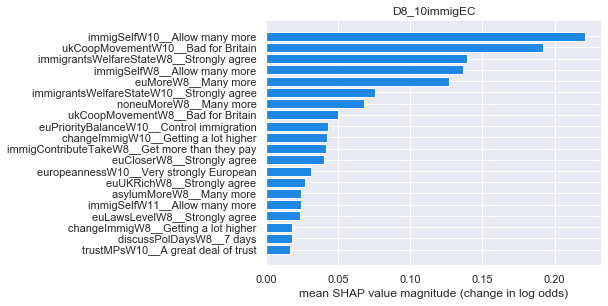

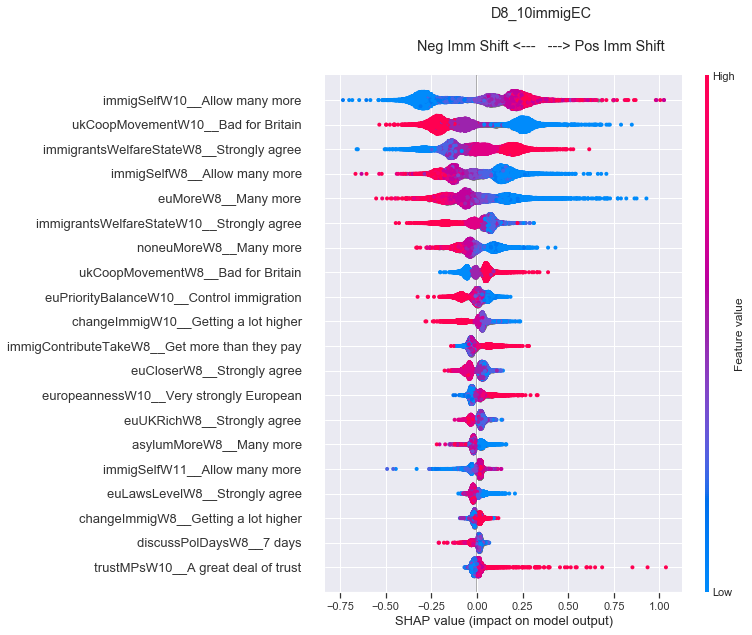

Wall time: 21min


(<shap.explainers.tree.TreeExplainer at 0xb896f48>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [27]:
%%time
colname = "D8_10immigEC"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nNeg Imm Shift <---   ---> Pos Imm Shift")

In [28]:
BES_reduced_with_na["immigECW8__Good for Econ&Cult"] = (BES_reduced_with_na["immigEconW8__Good for economy"] + BES_reduced_with_na["immigCulturalW8__Enriches cultural life"])/2

In [ ]:
# lets run it leaving the baseline W8 values in - see if that makes it easier to see *shift* drivers not related to baseline

In [ ]:
%%time
colname = "D8_10immigEC"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nNeg Imm Shift <---   ---> Pos Imm Shift")

[12:45:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.14033
Will train until validation_0-rmse hasn't improved in 13.5 rounds.
[1]	validation_0-rmse:2.11635
[2]	validation_0-rmse:2.09265
[3]	validation_0-rmse:2.06902
[4]	validation_0-rmse:2.05216
[5]	validation_0-rmse:2.03785
[6]	validation_0-rmse:2.03484
[7]	validation_0-rmse:2.01468
[8]	validation_0-rmse:2.00189
[9]	validation_0-rmse:1.98736
[10]	validation_0-rmse:1.98433
[11]	validation_0-rmse:1.96773
[12]	validation_0-rmse:1.9531
[13]	validation_0-rmse:1.94191
[14]	validation_0-rmse:1.92966
[15]	validation_0-rmse:1.92158
[16]	validation_0-rmse:1.91107
[17]	validation_0-rmse:1.90138
[18]	validation_0-rmse:1.90031
[19]	validation_0-rmse:1.89078
[20]	validation_0-rmse:1.88971
[21]	validation_0-rmse:1.88257
[22]	validation_0-rmse:1.88117


In [ ]:
# immigEconW8__Good for economy
# immigCulturalW8__Enriches cultural life

In [14]:
search(BES_reduced_with_na,"immigCultural")

immigCulturalW1__Enriches cultural life     29365
immigCulturalW2__Enriches cultural life     29061
immigCulturalW3__Enriches cultural life     27140
immigCulturalW4__Enriches cultural life     30172
immigCulturalW7__Enriches cultural life     29014
immigCulturalW8__Enriches cultural life     31900
immigCulturalW10__Enriches cultural life    28289
immigCulturalW11__Enriches cultural life    29115
immigCulturalW13__Enriches cultural life    29307
immigCulturalW14__Enriches cultural life    29081
immigCulturalW15__Enriches cultural life    28751
immigCulturalW16__Enriches cultural life    35197
immigCulturalW17__Enriches cultural life    31831
dtype: int64